<a href="https://colab.research.google.com/github/Yaakov-Sternberg/USD-Capstone-Project-to-Predict-Preterm-Infant-Bradycardia-Events-/blob/main/USD%2C_Capstone_Project%2C_Final_Version_of_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wfdb xgboost --quiet

import os
import glob
import shutil
import time
import warnings
import json
import random
from datetime import datetime
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple, Optional

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve,
    precision_recall_curve, confusion_matrix, accuracy_score
)

import xgboost as xgb
from scipy.signal import welch
from scipy.stats import wilcoxon

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import wfdb

warnings.filterwarnings('ignore')

# Seed for reproducibility
RANDOM_SEED = 1234

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    """Ensures DataLoader workers are also deterministic."""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Setup complete. Device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
Setup complete. Device: cpu


## Configurations

In [2]:
@dataclass
class Config:
    """Central configuration."""
    EXPERIMENT_NAME = "Merged_Optimized_Diagnostics"

    # Paths
    DRIVE_PATH = '/content/drive/MyDrive/picsdb'
    LOCAL_PATH = '/content/picsdb_local'
    RESULTS_BASE = '/content/drive/MyDrive/capstone_results'

    # Data parameters
    FS_GRID = 2.0
    WINDOW_LEN = 120.0
    HORIZON = 60.0

    # Dual Stride approaches for imbalance handling
    STRIDE = 10.0            # Normal Stride
    DENSE_STRIDE = 2.0       # Stride for positive regions
    POS_REGION_RADIUS = 90.0 # Seconds around brady event to sample densely

    LEAD_TIME = 0.5
    HR_CLIP_MIN = 40.0
    HR_CLIP_MAX = 220.0

    # Frequency Domain Features (HRV)
    LF_BAND = (0.04, 0.15)
    HF_BAND = (0.15, 0.4)

    # Split ratios
    TEMPORAL_TRAIN_RATIO = 0.7
    TEMPORAL_VAL_RATIO = 0.15
    HYBRID_WARMUP_RATIO = 0.3

    # Training
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-3
    N_EPOCHS = 30
    PATIENCE = 7
    WEIGHT_DECAY = 1e-4
    DROPOUT = 0.3
    MAX_POS_WEIGHT = 3.0
    GRAD_CLIP = 1.0

    # Oversampling: Target fraction of positives in each training batch
    TARGET_POSITIVE_RATIO = 0.3

    # Minimum FP penalty near events
    MIN_FP_WEIGHT = 0.2

    # Speed Optimization
    NUM_WORKERS = min(4, os.cpu_count() or 2)
    USE_TORCH_COMPILE = True

    # Diagnostic Thresholds
    OVERFIT_GAP_THRESHOLD = 0.10
    UNDERFIT_AUROC_THRESHOLD = 0.60

    # Models to run
    MODELS = ('CNN-BiLSTM', 'TCN', 'XGBoost', 'Random Forest', 'Logistic Regression')


config = Config()

OUTPUT_DIR = os.path.join(config.RESULTS_BASE, config.EXPERIMENT_NAME)
PROGRESS_FILE = os.path.join(OUTPUT_DIR, 'progress.json')

print(f"Output directory: {OUTPUT_DIR}")

fig_dir = os.path.join(OUTPUT_DIR, 'figures')
os.makedirs(fig_dir, exist_ok=True)

Output directory: /content/drive/MyDrive/capstone_results/Merged_Optimized_Diagnostics


## Checkpoint/resume logic

In [3]:
class ProgressTracker:
    def __init__(self, progress_file: str):
        self.progress_file = progress_file
        self.progress = self._load_progress()

    def _load_progress(self) -> dict:
        if os.path.exists(self.progress_file):
            with open(self.progress_file, 'r') as f:
                return json.load(f)
        return {'started_at': datetime.now().isoformat(), 'completed': [], 'failed': []}

    def _save_progress(self):
        self.progress['last_updated'] = datetime.now().isoformat()
        temp_file = self.progress_file + '.tmp'
        with open(temp_file, 'w') as f:
            json.dump(self.progress, f, indent=2)
        os.replace(temp_file, self.progress_file)


    def is_completed(self, task_id: str) -> bool:
        return task_id in self.progress['completed']

    def mark_completed(self, task_id: str):
        if task_id not in self.progress['completed']:
            self.progress['completed'].append(task_id)
            self._save_progress()
            print(f"Checkpoint saved: {task_id}")

    def mark_failed(self, task_id: str, error: str):
        self.progress['failed'].append({'task': task_id, 'error': error, 'time': datetime.now().isoformat()})
        self._save_progress()


## Mount Drive & Setup

In [4]:
import os
import shutil
from google.colab import drive

# Check if Drive is mounted
if os.path.ismount('/content/drive'):
    print("Google Drive is already successfully mounted.")

else:
    # If not mounted, check for folder blocking
    if os.path.exists('/content/drive'):
        # Deletes folder
        shutil.rmtree('/content/drive')

    # Create a fresh empty directory
    os.makedirs('/content/drive', exist_ok=True)

    # Mount with force_remount
    drive.mount('/content/drive', force_remount=True)

# Continue with directory setup
os.makedirs(OUTPUT_DIR, exist_ok=True)
for subdir in ['models', 'predictions', 'figures', 'data',
               'figures/learning_curves', 'figures/learning_curves_traditional',
               'loso/models', 'loso/predictions',
               'temporal/models', 'temporal/predictions',
               'hybrid/models', 'hybrid/predictions']:
    os.makedirs(os.path.join(OUTPUT_DIR, subdir), exist_ok=True)

tracker = ProgressTracker(PROGRESS_FILE)

if os.path.exists(config.DRIVE_PATH) and not os.path.exists(config.LOCAL_PATH):
    print("Copying data to local storage...")
    shutil.copytree(config.DRIVE_PATH, config.LOCAL_PATH)
    print("Data ready")
elif not os.path.exists(config.LOCAL_PATH):
    print(f"Warning: Data path {config.LOCAL_PATH} does not exist.")
else:
    print("Data directory already exists.")


Mounted at /content/drive
Copying data to local storage...
Data ready


## Plotting

In [5]:
def plot_learning_curves(history, model_name, subject_id, save_dir):
    epochs = np.arange(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Loss Curves
    ax1 = axes[0, 0]
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.fill_between(epochs, history['train_loss'], history['val_loss'], alpha=0.3, color='orange', label='Gap')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('BCE Loss')
    ax1.set_title(f'Loss Curves - {model_name} ({subject_id})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ## Gap Annotation
    final_loss_gap = history['val_loss'][-1] - history['train_loss'][-1]
    ax1.annotate(f'Final Gap: {final_loss_gap:.4f}', xy=(0.95, 0.95), xycoords='axes fraction',
                 ha='right', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))



    # AUROC Curves
    ax2 = axes[0, 1]
    ax2.plot(epochs, history['train_auroc'], 'b-', label='Train AUROC', linewidth=2)
    ax2.plot(epochs, history['val_auroc'], 'r-', label='Val AUROC', linewidth=2)
    ax2.axhline(0.5, color='gray', linestyle='--')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUROC')
    ax2.set_title('AUROC Curves')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    auroc_gap = history['train_auroc'][-1] - history['val_auroc'][-1]
    ax2.annotate(f'Train-Val Gap: {auroc_gap:.4f}', xy=(0.95, 0.05), xycoords='axes fraction',
                 ha='right', va='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))



    # Accuracy Curves
    ax3 = axes[1, 0]
    ax3.plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    ax3.plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.set_title('Accuracy Curves')
    ax3.legend()
    ax3.grid(True, alpha=0.3)



    # Diagnosis
    ax4 = axes[1, 1]
    ax4.axis('off')

    if auroc_gap > config.OVERFIT_GAP_THRESHOLD:
        diagnosis = "OVERFITTING"
        explanation = f"Train-Val AUROC gap ({auroc_gap:.3f}) exceeds {config.OVERFIT_GAP_THRESHOLD}"
    elif history['val_auroc'][-1] < config.UNDERFIT_AUROC_THRESHOLD:
        diagnosis = "UNDERFITTING"
        explanation = f"Val AUROC ({history['val_auroc'][-1]:.3f}) < {config.UNDERFIT_AUROC_THRESHOLD}"
    else:
        diagnosis = "GOOD FIT"
        explanation = "Healthy train-val gap with reasonable performance"

    diag_text = f"DIAGNOSIS\n{'='*20}\n\nFinal Tr Loss: {history['train_loss'][-1]:.4f}\nFinal Va Loss: {history['val_loss'][-1]:.4f}\n\nFinal Tr AUROC: {history['train_auroc'][-1]:.4f}\nFinal Va AUROC: {history['val_auroc'][-1]:.4f}\n\nResult: {diagnosis}\n{explanation}"

    ax4.text(0.1, 0.9, diag_text, transform=ax4.transAxes, fontsize=10, verticalalignment='top',
             fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"curve_{model_name.replace(' ', '_')}_{subject_id}.png"), dpi=150)
    plt.close()

    # Updated return to include diagnosis data
    return {
        'diagnosis': diagnosis,
        'explanation': explanation,
        'auroc_gap': auroc_gap,
        'loss_gap': final_loss_gap
    }


def plot_traditional_learning_curves(history, model_name, subject_id, strategy, save_dir):
    """Plots learning dynamics for Traditional Models."""
    os.makedirs(save_dir, exist_ok=True)

    if 'n_rounds' in history: # XGBoost
        rounds = np.arange(1, history['n_rounds'] + 1)
        plt.figure(figsize=(6, 4))
        plt.plot(rounds, history['train_auroc'], label='Train')
        plt.plot(rounds, history['val_auroc'], label='Val')
        plt.title(f'{model_name} ({strategy}) – {subject_id}')
        plt.xlabel('Rounds'); plt.ylabel('AUROC')
        plt.legend(); plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(save_dir, f"{model_name}_{strategy}_{subject_id}_lc.png"))
        plt.close()

    elif 'train_size' in history: # RF/LogReg
        plt.figure(figsize=(6, 4))
        plt.plot(history['train_size'], history['train_auroc'], marker='o', label='Train')
        plt.plot(history['train_size'], history['val_auroc'], marker='o', label='Val')
        plt.title(f'{model_name} Learning Curve\n({strategy} – {subject_id})')
        plt.xlabel('Train Size'); plt.ylabel('AUROC')
        plt.legend(); plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(save_dir, f"{model_name}_{strategy}_{subject_id}_lc.png"))
        plt.close()

def plot_aggregate_learning_curves():
    """Aggregate DL learning curves (CNN-BiLSTM / TCN only)."""
    print("\nGenerating aggregate learning curves...")

    strategies = ['loso', 'temporal', 'hybrid']
    agg_dir = os.path.join(fig_dir, 'aggregate')
    os.makedirs(agg_dir, exist_ok=True)

    required_keys = ['train_loss', 'val_loss', 'train_auroc', 'val_auroc']

    for strategy in strategies:
        model_dir = os.path.join(OUTPUT_DIR, strategy, 'models')
        if not os.path.exists(model_dir):
            continue

        histories = []
        for f in os.listdir(model_dir):
            if not f.endswith('_history.npz'):
                continue

            path = os.path.join(model_dir, f)
            try:
                data = np.load(path, allow_pickle=True)
            except Exception:
                continue

            #  Only keep files that have ALL the deep-learning keys
            if not all(k in data.files for k in required_keys):
                # This is likely a traditional model history (e.g., XGBoost / RF / LogReg)
                continue

            histories.append({
                'train_loss':  data['train_loss'].tolist(),
                'val_loss':    data['val_loss'].tolist(),
                'train_auroc': data['train_auroc'].tolist(),
                'val_auroc':   data['val_auroc'].tolist(),
            })

        # If no valid DL histories for this strategy, skip it
        if not histories:
            continue

        # Find maximum number of epochs across histories
        max_epochs = max(len(h['train_loss']) for h in histories)

        # Pad histories with NaNs for alignment
        train_losses = np.array([
            h['train_loss'] + [np.nan] * (max_epochs - len(h['train_loss']))
            for h in histories
        ])
        val_losses = np.array([
            h['val_loss'] + [np.nan] * (max_epochs - len(h['val_loss']))
            for h in histories
        ])
        train_aurocs = np.array([
            h['train_auroc'] + [np.nan] * (max_epochs - len(h['train_auroc']))
            for h in histories
        ])
        val_aurocs = np.array([
            h['val_auroc'] + [np.nan] * (max_epochs - len(h['val_auroc']))
            for h in histories
        ])

        epochs = np.arange(1, max_epochs + 1)

        # Compute means and stds, ignoring NaNs
        mean_train_loss = np.nanmean(train_losses, axis=0)
        mean_val_loss   = np.nanmean(val_losses, axis=0)
        std_train_loss  = np.nanstd(train_losses, axis=0)
        std_val_loss    = np.nanstd(val_losses, axis=0)

        mean_train_auroc = np.nanmean(train_aurocs, axis=0)
        mean_val_auroc   = np.nanmean(val_aurocs, axis=0)
        std_train_auroc  = np.nanstd(train_aurocs, axis=0)
        std_val_auroc    = np.nanstd(val_aurocs, axis=0)

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Loss plot
        ax1 = axes[0]
        ax1.plot(epochs, mean_train_loss, 'b-', lw=2, label='Train')
        ax1.plot(epochs, mean_val_loss,   'r-', lw=2, label='Val')
        ax1.fill_between(
            epochs,
            mean_train_loss - std_train_loss,
            mean_train_loss + std_train_loss,
            alpha=0.2,
            color='blue'
        )
        ax1.fill_between(
            epochs,
            mean_val_loss - std_val_loss,
            mean_val_loss + std_val_loss,
            alpha=0.2,
            color='red'
        )
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'{strategy.upper()} - Aggregate Loss (n={len(histories)})')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # AUROC plot
        ax2 = axes[1]
        ax2.plot(epochs, mean_train_auroc, 'b-', lw=2, label='Train')
        ax2.plot(epochs, mean_val_auroc,   'r-', lw=2, label='Val')
        ax2.fill_between(
            epochs,
            mean_train_auroc - std_train_auroc,
            mean_train_auroc + std_train_auroc,
            alpha=0.2,
            color='blue'
        )
        ax2.fill_between(
            epochs,
            mean_val_auroc - std_val_auroc,
            mean_val_auroc + std_val_auroc,
            alpha=0.2,
            color='red'
        )
        ax2.axhline(0.5, color='gray', ls='--')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('AUROC')
        ax2.set_title(f'{strategy.upper()} - Aggregate AUROC')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0.4, 1.0)

        plt.tight_layout()
        out_path = os.path.join(agg_dir, f'aggregate_{strategy}_curves.png')
        plt.savefig(out_path, dpi=150)
        plt.close()

        print(f"  Saved aggregate curves for {strategy.upper()} to {out_path}")

def plot_overfitting_analysis(results_df):
    """
    Create an overfitting analysis scatter plot:
    Train AUROC vs Val AUROC for each run, by strategy and model.
    """
    print("\nGenerating overfitting analysis plot...")

    # If train_auroc was not saved, we can't do this plot
    if 'train_auroc' not in results_df.columns or 'val_auroc' not in results_df.columns:
        print("  train_auroc / val_auroc not found in results_df – skipping overfitting analysis.")
        return

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    strategies = ['LOSO', 'Temporal', 'Hybrid']

    for idx, strategy in enumerate(strategies):
        ax = axes[idx]
        subset = results_df[results_df['strategy'] == strategy]

        if len(subset) == 0:
            ax.axis('off')
            ax.set_title(f'{strategy}\n(no runs)')
            continue

        # Scatter: Train AUROC vs Val AUROC, colored by model
        for model in config.MODELS:
            model_subset = subset[subset['model'] == model]
            if len(model_subset) == 0:
                continue
            ax.scatter(
                model_subset['train_auroc'],
                model_subset['val_auroc'],
                label=model,
                alpha=0.7,
                s=50
            )

        # Diagonal "perfect generalization" line
        ax.plot([0.4, 1.0], [0.4, 1.0], 'k--', alpha=0.5, label='Perfect')

        # Overfitting good-fit zone
        lower_good = np.array([0.4 - config.OVERFIT_GAP_THRESHOLD, 1.0 - config.OVERFIT_GAP_THRESHOLD])
        upper_good = np.array([0.4, 1.0])
        ax.fill_between(
            [0.4, 1.0],
            lower_good,
            upper_good,
            alpha=0.1,
            color='green',
            label='Good fit zone'
        )

        ax.set_xlabel('Train AUROC')
        ax.set_ylabel('Val AUROC')
        ax.set_title(strategy)
        ax.set_xlim(0.4, 1.0)
        ax.set_ylim(0.4, 1.0)
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.suptitle('Overfitting Analysis: Train vs Val AUROC', fontsize=12)
    plt.tight_layout()
    out_path = os.path.join(fig_dir, 'overfitting_analysis.png')
    plt.savefig(out_path, dpi=150)
    plt.close()
    print(f"  Saved overfitting analysis plot to {out_path}")

## Data Loading Functions

Vectorized with Dynamic Stride to increase positive sample size

In [6]:
def load_hr_series(rec_ecg_rel, base_dir):
    rec_path = os.path.join(base_dir, rec_ecg_rel)
    header = wfdb.rdheader(rec_path)
    brady_ann = wfdb.rdann(rec_path, 'atr')
    brady_times = np.array(brady_ann.sample) / header.fs
    r_ann = wfdb.rdann(rec_path, 'qrsc')
    r_times = np.array(r_ann.sample) / header.fs
    RR = np.diff(r_times)
    return r_times[1:], 60.0 / RR, brady_times

def load_resp_waveform(rec_ecg_rel, base_dir):
    dirname, basename = os.path.split(rec_ecg_rel)
    infant_prefix = basename.split("_")[0]
    resp_path = os.path.join(base_dir, dirname, infant_prefix + "_resp")
    resp_record = wfdb.rdrecord(resp_path)
    return np.arange(len(resp_record.p_signal)) / resp_record.fs, resp_record.p_signal[:, 0]

def resample_hr_and_resp(hr_times, HR, t_resp, resp_signal):
    HR_clip = np.clip(HR, config.HR_CLIP_MIN, config.HR_CLIP_MAX)
    t_start, t_end = max(hr_times[0], t_resp[0]), min(hr_times[-1], t_resp[-1])
    t_grid = np.arange(t_start, t_end, 1.0 / config.FS_GRID)
    return t_grid, np.interp(t_grid, hr_times, HR_clip), np.interp(t_grid, t_resp, resp_signal)

def make_windows(t_grid, hr_grid, resp_grid, brady_times, config, lead_time=None):
    """
    Vectorized window generation with dynamic positive-region sampling & distance return
    """
    if lead_time is None:
        lead_time = config.LEAD_TIME

    L = int(config.WINDOW_LEN * config.FS_GRID)
    step = int(config.DENSE_STRIDE * config.FS_GRID)

    horizon_steps = int(config.HORIZON * config.FS_GRID)
    gap_steps = int(lead_time * config.FS_GRID)

    data = np.stack([hr_grid, resp_grid], axis=0)
    windows = sliding_window_view(data, window_shape=L, axis=1)[:, ::step, :]
    windows = windows.transpose(1, 0, 2)

    n_windows = windows.shape[0]
    indices = np.arange(0, n_windows * step, step)
    times = t_grid[indices]

    pred_starts = times + config.WINDOW_LEN + lead_time
    pred_ends   = pred_starts + config.HORIZON

    brady_times = np.sort(brady_times)
    idx_start = np.searchsorted(brady_times, pred_starts)
    idx_end   = np.searchsorted(brady_times, pred_ends)
    y = (idx_end > idx_start).astype(np.int64)

    valid_mask = (indices + L + gap_steps + horizon_steps) <= len(t_grid)

    windows     = windows[valid_mask]
    y           = y[valid_mask]
    times       = times[valid_mask]
    pred_starts = pred_starts[valid_mask]

    # Distance to nearest brady event for every window
    if len(brady_times) > 0:
        b_idx = np.searchsorted(brady_times, pred_starts)
        b_idx = np.clip(b_idx, 0, len(brady_times) - 1)

        dist_right = np.abs(pred_starts - brady_times[b_idx])
        dist_left  = np.abs(
            pred_starts - brady_times[np.clip(b_idx - 1, 0, len(brady_times) - 1)]
        )
        min_dist = np.minimum(dist_left, dist_right)
    else:
        # No events in this record; treat as "far away"
        min_dist = np.full_like(pred_starts, fill_value=config.POS_REGION_RADIUS * 2.0, dtype=float)

    # DYNAMIC SAMPLING LOGIC
    if len(brady_times) > 0:
        is_dense_region = min_dist <= config.POS_REGION_RADIUS
    else:
        is_dense_region = np.zeros(len(times), dtype=bool)

    stride_ratio = int(config.STRIDE / config.DENSE_STRIDE)
    window_indices = np.arange(len(times))
    is_grid_aligned = (window_indices % stride_ratio) == 0

    keep_mask = is_dense_region | is_grid_aligned

    # Also return min_dist for kept windows
    return (
        windows[keep_mask].astype(np.float32),
        y[keep_mask],
        times[keep_mask],
        min_dist[keep_mask].astype(np.float32),
    )

def load_infant(rec_ecg_rel, base_dir):
    hr_times, HR, brady_times = load_hr_series(rec_ecg_rel, base_dir)
    t_resp, resp_sig = load_resp_waveform(rec_ecg_rel, base_dir)
    t_grid, hr_grid, resp_grid = resample_hr_and_resp(hr_times, HR, t_resp, resp_sig)
    X, y, times, dist_to_event = make_windows(t_grid, hr_grid, resp_grid, brady_times, config)
    sort_idx = np.argsort(times)
    return (
        X[sort_idx],
        y[sort_idx],
        times[sort_idx],
        dist_to_event[sort_idx],
    )

## Load Data

In [7]:
# Renamed cache file to automatically force rebuild without manual deletion
data_cache_path = os.path.join(OUTPUT_DIR, 'data', 'infant_data_cache_time_aware.npz')
metadata_path = os.path.join(OUTPUT_DIR, 'data', 'infant_metadata_time_aware.csv')

if os.path.exists(data_cache_path) and os.path.exists(metadata_path):
    cache = np.load(data_cache_path, allow_pickle=True)
    infant_data = cache['infant_data'].item()
else:
    if os.path.exists(config.LOCAL_PATH):
        hea_files = glob.glob(os.path.join(config.LOCAL_PATH, "**", "*.hea"), recursive=True)
        record_names = [os.path.relpath(os.path.splitext(p)[0], config.LOCAL_PATH) for p in hea_files]
        ecg_records = sorted([r for r in record_names if r.endswith("_ecg")])

        infant_data = {}
        metadata = []

        for rec in ecg_records:
            X, y, times, dist_to_event = load_infant(rec, config.LOCAL_PATH)
            infant_id = os.path.basename(rec).split("_")[0]
            infant_data[infant_id] = {
                'X': X,
                'y': y,
                'times': times,
                'dist_to_event': dist_to_event,   # NEW
            }
            metadata.append({'infant_id': infant_id, 'n_windows': len(y), 'n_pos': int(y.sum())})
            print(f"  {infant_id}: {len(y):,} windows (Pos: {y.sum()})")

        np.savez(data_cache_path, infant_data=infant_data)
        pd.DataFrame(metadata).to_csv(metadata_path, index=False)
    else:
        print("Data source not found. Please ensure LOCAL_PATH is correct.")
        infant_data = {}

## Model DEfinitions

In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sample_weight: Optional[np.ndarray] = None):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        if sample_weight is not None:
            self.w = torch.from_numpy(sample_weight.astype(np.float32))
        else:
            self.w = None

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if self.w is None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx], self.y[idx], self.w[idx]

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        scores = self.attention(x)
        weights = F.softmax(scores, dim=1)
        context = torch.sum(weights * x, dim=1)
        return context, weights

class CNNBiLSTM(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 32, 5, padding=2), nn.BatchNorm1d(32), nn.ReLU(),
            nn.Conv1d(32, 64, 3, padding=1), nn.BatchNorm1d(64), nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.lstm = nn.LSTM(64, 64, batch_first=True, bidirectional=True)
        self.attention = Attention(128)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(dropout), nn.Linear(64, 1))

    def forward(self, x):
        x = self.cnn(x).permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        context, _ = self.attention(lstm_out)
        return self.fc(self.dropout(context)).squeeze(1)

class Chomp1d(nn.Module):
    """
    Remove extra timesteps introduced by right padding so that
    causal convolutions keep the same effective length.
    """
    def __init__(self, chomp_size: int):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        if self.chomp_size == 0:
            return x
        return x[:, :, :-self.chomp_size]


class TemporalBlock(nn.Module):
    """
    Hybrid Temporal Block:
      - Dilated causal convs
      - BatchNorm for stability
      - Residual connection (with 1x1 conv if channels change)
      - Dropout for regularization
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        dilation: int,
        dropout: float = 0.3,
    ):
        super().__init__()
        padding = (kernel_size - 1) * dilation  # causal padding

        # Conv 1
        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding=padding,
            dilation=dilation,
        )
        self.chomp1 = Chomp1d(padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)

        # Conv 2
        self.conv2 = nn.Conv1d(
            out_channels,
            out_channels,
            kernel_size,
            padding=padding,
            dilation=dilation,
        )
        self.chomp2 = Chomp1d(padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout)

        # Residual path
        self.downsample = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else None
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.drop1(out)

        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.drop2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TCNModel(nn.Module):
    """
    Hybrid TCN classifier:
      - Input:  (B, 2, T)
      - Output: logits (B,)
      - Strategy: Concatenates GAP (state) and Last-Timestep (trajectory)
                  to capture both sustained distress and sudden events.
    """
    def __init__(
        self,
        dropout: float = 0.3,
        num_channels: tuple = (32, 64, 64, 128, 128),
        kernel_size: int = 3,
    ):
        super().__init__()

        layers = []
        in_ch = 2

        for i, out_ch in enumerate(num_channels):
            dilation = 2 ** i
            layers.append(
                TemporalBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    dropout=dropout
                )
            )
            in_ch = out_ch

        self.tcn = nn.Sequential(*layers)

        # Concat (Mean_Pool, Last_Step
        combined_dim = num_channels[-1] * 2

        self.fc = nn.Sequential(
            nn.Linear(combined_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        # x: (B, 2, T)
        features = self.tcn(x)      # (B, C_last, T)

        # 1. Global Average Pooling (The "State")
        gap = features.mean(dim=2)  # (B, C_last)

        # 2. Last Timestep (The "Trajectory")
        last = features[:, :, -1]   # (B, C_last)

        # 3. Concatenate
        combined = torch.cat([gap, last], dim=1)  # (B, C_last * 2)

        y = self.fc(combined)       # (B, 1)
        return y.squeeze(1)


class TraditionalML:
    def __init__(self, model_type, config):
        self.model_type = model_type
        self.config = config
        self.RANDOM_SEED = RANDOM_SEED
        self.history_ = {}

        if model_type == 'XGBoost':
            # Use 'hist' tree method (speed optimization)
            xgb_params = {
                'n_estimators': 100,
                'scale_pos_weight': 1.0,           # placeholder, overridden in fit()
                'eval_metric': ['logloss', 'auc'],
                'random_state': self.RANDOM_SEED,
                'n_jobs': -1
            }

            # Use GPU if available
            if torch.cuda.is_available():
                xgb_params['tree_method'] = 'gpu_hist'
                xgb_params['predictor'] = 'gpu_predictor'
            else:
                xgb_params['tree_method'] = 'hist'

            self.model = xgb.XGBClassifier(**xgb_params)

        elif model_type == 'Random Forest':
            self.model = RandomForestClassifier(
                n_estimators=200,
                max_depth=15,
                class_weight='balanced',
                random_state=self.RANDOM_SEED,
                n_jobs=-1
            )

        else:  # Logistic Regression
            self.model = LogisticRegression(
                class_weight='balanced',
                max_iter=1000,
                random_state=self.RANDOM_SEED,
                n_jobs=-1 # sklearn uses this where possible
            )

        self.scaler = StandardScaler()
        self.impute_values_ = None

    @property
    def feature_names(self):
        """Returns the list of feature names in the exact order of extraction."""
        # 1. Basic Stats (10 per signal * 2 signals = 20)
        stats = ['Mean', 'Std', 'Min', 'Max', 'P25', 'P50', 'P75',
                 'Range', 'DiffMean', 'DiffStd']
        names = [f"HR_{s}" for s in stats] + [f"Resp_{s}" for s in stats]

        # 2. Clinical HR (3)
        names.extend(['Rapid_Decels', 'Max_Decel_Rate', 'Time_Under_100'])
        # 3. Trend (1)
        names.append('HR_Slope')
        # 4. Coupling (1)
        names.append('HR_Resp_Corr')
        # 5. Spectral/HRV (3)
        names.extend(['LF_Power', 'HF_Power', 'LF_HF_Ratio'])
        return names

    def get_feature_importance(self):
        # return feature importance depending on model type
        names = self.feature_names
        if self.model_type == 'Logistic Regression':
            importances = np.abs(self.model.coef_[0])
        elif hasattr(self.model, 'feature_importances_'):
            importances = self.model.feature_importances_
        else:
            return pd.DataFrame()

        return (
            pd.DataFrame({'Feature': names, 'Importance': importances})
              .sort_values(by='Importance', ascending=False)
        )

    def _features(self, X):
        """
        Fully Vectorized Feature Extraction.
        (Faster than looping with matrix operations.)
        """
        # X shape: (N, 2, L) -> N windows, 2 signals, L timesteps
        hr = X[:, 0, :]    # (N, L)
        resp = X[:, 1, :]  # (N, L)

        N, L = hr.shape

        # Basic Stats (Vectorized)
        # Calculate stats for HR & Resp simultaneously

        feats = []

        for sig in [hr, resp]:
            diff = np.diff(sig, axis=1) # (N, L-1)

            # Percentiles
            p25 = np.percentile(sig, 25, axis=1)
            p50 = np.percentile(sig, 50, axis=1)
            p75 = np.percentile(sig, 75, axis=1)

            feats.extend([
                np.mean(sig, axis=1),
                np.std(sig, axis=1),
                np.min(sig, axis=1),
                np.max(sig, axis=1),
                p25,
                p50,
                p75,
                sig[:, -1] - sig[:, 0], # Range (End - Start)
                np.mean(diff, axis=1),
                np.std(diff, axis=1)
            ])

        # Clinical HR features (Vectorized)
        hr_diff = np.diff(hr, axis=1)

        feats.extend([
            np.sum(hr_diff < -2, axis=1),  # Rapid Decels count
            np.min(hr_diff, axis=1),       # Max decel rate (min value of diff)
            np.sum(hr < 100, axis=1)       # Time under 100
        ])

        # Trend: Slope (Vectorized Linear Regression)
        # Slope = cov(x, y) / var(x)
        # Since x (time) is 0..L-1 for all windows, we can precompute x components
        x_axis = np.arange(L)
        x_mean = np.mean(x_axis)
        x_centered = x_axis - x_mean
        denom = np.sum(x_centered ** 2)

        # Center HR windows
        hr_mean = np.mean(hr, axis=1, keepdims=True)
        hr_centered = hr - hr_mean

        # Vectorized dot product (numerator of slope formula)
        # (N, L) @ (L,) -> (N,)
        numer = np.dot(hr_centered, x_centered)
        slope = numer / denom
        feats.append(slope)

        # Coupling: Correlation (Vectorized Pearson)
        # Corr = E[(X-Ux)(Y-Uy)] / (Sx * Sy)

        # We already have hr_centered. Need resp_centered.
        resp_mean = np.mean(resp, axis=1, keepdims=True)
        resp_centered = resp - resp_mean

        # Covariance numerator
        cov_num = np.sum(hr_centered * resp_centered, axis=1)

        # Standard deviations (N,)
        hr_std = np.std(hr, axis=1)
        resp_std = np.std(resp, axis=1)

        # Avoid div by zero
        denom_corr = (hr_std * resp_std * L)
        # Using population std (numpy default), formula matches np.corrcoef logic approx
        # Actually, simpler: sum((x-mx)(y-my)) / sqrt(sum((x-mx)^2) * sum((y-my)^2))
        denom_corr_geo = np.sqrt(np.sum(hr_centered**2, axis=1) * np.sum(resp_centered**2, axis=1))

        corr = np.divide(cov_num, denom_corr_geo, out=np.zeros_like(cov_num), where=denom_corr_geo!=0)
        feats.append(corr)

        # Spectral / HRV (Vectorized Welch)
        # scipy.signal.welch supports axis argument
        freqs, Pxx = welch(hr, fs=self.config.FS_GRID, nperseg=L, axis=-1)

        # Masks for bands (freqs is 1D array)
        lf_mask = (freqs >= 0.04) & (freqs <= 0.15)
        hf_mask = (freqs >= 0.15) & (freqs <= 0.4)

        # Integrate (Trapezoidal rule) along the frequency axis
        # Pxx is (N, n_freqs)

        # LF Power
        if np.any(lf_mask):
            lf = np.trapz(Pxx[:, lf_mask], freqs[lf_mask], axis=1)
        else:
            lf = np.zeros(N)

        # HF Power
        if np.any(hf_mask):
            hf = np.trapz(Pxx[:, hf_mask], freqs[hf_mask], axis=1)
        else:
            hf = np.zeros(N)

        feats.append(lf)
        feats.append(hf)

        # Ratio with safe divide
        ratio = np.divide(lf, hf + 1e-6, out=np.zeros_like(lf), where=hf > 1e-9)
        feats.append(ratio)

        # Stack all feature arrays: List of 1D (N,) arrays -> (N, n_features)
        return np.column_stack(feats)

    def _prepare_data(self, X, is_train=True):
        """Feature extraction + NaN imputation + scaling."""
        # This now calls the Vectorized _features
        feats = self._features(X)
        feats[~np.isfinite(feats)] = np.nan

        if is_train:
            # Column-wise means for imputation
            self.impute_values_ = np.nan_to_num(
                np.nanmean(feats, axis=0),
                nan=0.0
            )

        idx_nan = np.isnan(feats)
        if np.any(idx_nan):
            feats[idx_nan] = np.take(
                self.impute_values_,
                np.where(idx_nan)[1]
            )

        if is_train:
            return self.scaler.fit_transform(feats)
        else:
            return self.scaler.transform(feats)

    def fit(
        self,
        X_train,
        y_train,
        X_val=None,
        y_val=None,
        subject_id="unknown",
        strategy="unknown",
        save_history_path=None
    ):
        feats_train = self._prepare_data(X_train, is_train=True)
        feats_val = (
            self._prepare_data(X_val, is_train=False)
            if X_val is not None
            else None
        )

        history = {}

        # XGBoost: dynamic scale_pos_weight per fold
        if self.model_type == 'XGBoost':
            n_pos = np.sum(y_train == 1)
            n_neg = np.sum(y_train == 0)

            if n_pos > 0:
                spw = n_neg / float(n_pos)
            else:
                spw = 1.0  # degenerate all-negative case

            self.model.set_params(scale_pos_weight=spw)
            print(f"[XGBoost] Using dynamic scale_pos_weight={spw:.3f} for this fold")

            if feats_val is not None:
                eval_set = [(feats_train, y_train), (feats_val, y_val)]
                self.model.fit(feats_train, y_train, eval_set=eval_set, verbose=False)
                results = self.model.evals_result()

                # We asked for eval_metric=['logloss','auc'], so 'auc' is available:
                #   results['validation_0']['auc'], results['validation_1']['auc']
                if 'validation_0' in results and 'auc' in results['validation_0']:
                    history['train_auroc'] = results['validation_0']['auc']
                    history['val_auroc'] = results['validation_1']['auc']
                    history['n_rounds'] = len(history['train_auroc'])
                    self.history_ = history
            else:
                self.model.fit(feats_train, y_train)

        elif self.model_type in ['Random Forest', 'Logistic Regression'] and feats_val is not None:
            # Learning curve style analysis
            rng = np.random.RandomState(self.RANDOM_SEED)
            n = len(feats_train)
            fracs = [0.1, 0.25, 0.5, 0.75, 1.0]
            train_au, val_au, sizes = [], [], []

            for frac in fracs:
                k = max(50, int(n * frac))
                idx = rng.choice(n, size=k, replace=False)
                X_sub, y_sub = feats_train[idx], y_train[idx]

                if self.model_type == 'Random Forest':
                    temp = RandomForestClassifier(
                        n_estimators=self.model.n_estimators,
                        max_depth=self.model.max_depth,
                        class_weight='balanced',
                        random_state=self.RANDOM_SEED,
                        n_jobs=-1
                    )
                else:
                    temp = LogisticRegression(
                        class_weight='balanced',
                        max_iter=1000,
                        random_state=self.RANDOM_SEED,
                        n_jobs=-1
                    )

                temp.fit(X_sub, y_sub)
                try:
                    train_au.append(
                        roc_auc_score(y_sub, temp.predict_proba(X_sub)[:, 1])
                    )
                except Exception:
                    train_au.append(0.5)

                try:
                    val_au.append(
                        roc_auc_score(y_val, temp.predict_proba(feats_val)[:, 1])
                    )
                except Exception:
                    val_au.append(0.5)

                sizes.append(k)

            history['train_size'] = sizes
            history['train_auroc'] = train_au
            history['val_auroc'] = val_au
            self.history_ = history
            self.model.fit(feats_train, y_train)

        else:
            # No validation data: just fit
            self.model.fit(feats_train, y_train)

        # Save history for diagnostics
        if save_history_path and self.history_:
            np.savez(
                save_history_path,
                **history,
                model_type=self.model_type,
                subject_id=subject_id,
                strategy=strategy
            )

        # Return train AUROC
        train_probs = self.model.predict_proba(feats_train)[:, 1]
        return roc_auc_score(y_train, train_probs)

    def predict_proba(self, X):
        feats = self._prepare_data(X, is_train=False)
        return self.model.predict_proba(feats)[:, 1]

## Training Loops

In [9]:
def compute_metrics(y_true, probs, threshold=0.5):
    """Calculates AUROC, AUPRC, and Accuracy for diagnostics."""
    try:
        auroc = roc_auc_score(y_true, probs)
    except Exception:
        auroc = 0.5
    try:
        auprc = average_precision_score(y_true, probs)
    except Exception:
        auprc = 0.0
    preds = (probs >= threshold).astype(int)
    acc = accuracy_score(y_true, preds)
    return auroc, auprc, acc

def standardize(X_train, X_val, X_test):
    mean, std = X_train.mean(axis=(0, 2), keepdims=True), X_train.std(axis=(0, 2), keepdims=True) + 1e-8
    return (X_train - mean) / std, (X_val - mean) / std, (X_test - mean) / std

def make_weighted_sampler_with_target(y_np: np.ndarray, target_pos_ratio: float) -> WeightedRandomSampler:
    """
    Create a WeightedRandomSampler that aims for a given positive fraction
    in the sampled batches.

    target_pos_ratio: desired positive fraction in (0,1).
    For heavy imbalance, values like 0.2–0.3 are typically 'mild'.
    """
    y_t = torch.from_numpy(y_np.astype(np.int64))
    n_pos = int((y_t == 1).sum())
    n_neg = int((y_t == 0).sum())
    N = n_pos + n_neg

    # Edge cases: if only one class exists, fall back to uniform sampling
    if n_pos == 0 or n_neg == 0 or N == 0:
        sample_weights = torch.ones_like(y_t, dtype=torch.float32)
        return WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )

    p_pos = n_pos / N
    p_neg = n_neg / N

    eps = 1e-6
    t_pos = float(target_pos_ratio)
    t_pos = max(min(t_pos, 0.95), 0.05)  # keep within reasonable bounds
    t_neg = 1.0 - t_pos

    # Class weights that push the effective sampling distribution toward t_pos / t_neg
    w_pos_raw = t_pos / (p_pos + eps)
    w_neg_raw = t_neg / (p_neg + eps)

    # Normalize so average weight is ~1.0 (not strictly necessary, but tidy)
    mean_w = 0.5 * (w_pos_raw + w_neg_raw)
    w_pos = w_pos_raw / (mean_w + eps)
    w_neg = w_neg_raw / (mean_w + eps)

    weights_per_class = torch.tensor([w_neg, w_pos], dtype=torch.float32)
    sample_weights = weights_per_class[y_t]

    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

def build_sample_weights(
    y_np: np.ndarray,
    dist_np: np.ndarray,
    pos_weight_scalar: float,
    radius: Optional[float] = None,
    min_fp_weight: Optional[float] = None,
) -> np.ndarray:
    """
    Build per-sample weights combining:
      - class cost-sensitivity (pos_weight_scalar for positives)
      - time-aware FP de-emphasis for negatives near events.

    y_np: labels {0,1}, shape (N,)
    dist_np: distance to nearest event in seconds, shape (N,)
    pos_weight_scalar: class weight for positives
    radius: within this many seconds, FP penalty ramps from min_fp_weight -> 1
    min_fp_weight: FP weight at distance=0 (0-1; e.g. 0.2)
    """
    if radius is None:
        radius = config.POS_REGION_RADIUS
    if min_fp_weight is None:
        min_fp_weight = config.MIN_FP_WEIGHT

    y = y_np.astype(np.float32)
    d = dist_np.astype(np.float32)

    # Clip distances; beyond radius, we treat all as "far"
    d_clipped = np.minimum(d, radius)
    normalized = d_clipped / (radius + 1e-6)

    # For negatives: linear ramp [0, radius] -> [min_fp_weight, 1.0]
    neg_time_factor = min_fp_weight + (1.0 - min_fp_weight) * normalized

    # Base class weights: positives get pos_weight_scalar, negatives get 1.0
    w_class = np.where(y == 1.0, pos_weight_scalar, 1.0)

    # Time factor only affects negatives
    w_time = np.where(y == 1.0, 1.0, neg_time_factor)

    w = w_class * w_time
    return w.astype(np.float32)


def train_deep_model(
    model_name,
    X_train, y_train, dist_train,
    X_val,   y_val,
    device,
    save_path=None,
    history_path=None,
    subject_id="unknown",
    strategy="unknown",
):
    # Build the chosen architecture
    if model_name == 'CNN-BiLSTM':
        model = CNNBiLSTM(config.DROPOUT).to(device)
    elif model_name == 'TCN':
        # use_gap=True because GAP outperformed last-timestep in the quick diagnostic
        model = TCNModel(dropout=config.DROPOUT).to(device)
    else:
        raise ValueError(f"Unknown deep model '{model_name}'")

    # Persistent Workers + Pin Memory + Seeded Worker
    g = torch.Generator()
    g.manual_seed(RANDOM_SEED)

    # class imbalance weight (scalar)
    n_pos = y_train.sum()
    n_neg = len(y_train) - y_train.sum()
    pos_weight_scalar = float(min(n_neg / (n_pos + 1e-6), config.MAX_POS_WEIGHT))

    # build time-aware, class-weighted per-sample weights
    sample_w_train = build_sample_weights(
        y_np=y_train,
        dist_np=dist_train,
        pos_weight_scalar=pos_weight_scalar,
        radius=config.POS_REGION_RADIUS,
        min_fp_weight=config.MIN_FP_WEIGHT,
    )

    # dataset + WeightedRandomSampler for training
    train_dataset = TimeSeriesDataset(X_train, y_train, sample_weight=sample_w_train)

    sampler = make_weighted_sampler_with_target(
        y_np=y_train,
        target_pos_ratio=config.TARGET_POSITIVE_RATIO
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        sampler=sampler,          # use sampler
        shuffle=False,            # must be False when sampler is set
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
        persistent_workers=True,
        worker_init_fn=seed_worker,
        generator=g
    )

    val_loader = DataLoader(
        TimeSeriesDataset(X_val, y_val),
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
        persistent_workers=True
    )

    # Per-sample BCE; we'll apply weights manually
    criterion = nn.BCEWithLogitsLoss(reduction='none')

    optimizer = optim.Adam(
        model.parameters(),
        lr=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=3
    )

    # Initialize GradScaler for Mixed Precision Training (speed optimzation)
    scaler = amp.GradScaler()

    best_auroc = -1
    best_state = None
    patience_ctr = 0

    # Tracking Accuracy for Plots
    history = {'train_loss': [], 'val_loss': [], 'train_auroc': [], 'val_auroc': [], 'train_acc': [], 'val_acc': []}

    print(f"{'Epoch':^5} | {'Tr Loss':^8} | {'Va Loss':^8} | {'Tr AUC':^8} | {'Va AUC':^8} | {'Status'}")
    print("-" * 65)

    for epoch in range(config.N_EPOCHS):
        model.train()
        train_losses, train_probs, train_labels = [], [], []

        for batch in train_loader:
            # batch may be (X, y, w) or (X, y)
            if len(batch) == 3:
                X_b, y_b, w_b = batch
                w_b = w_b.to(device, non_blocking=True)
            else:
                X_b, y_b = batch
                w_b = None

            optimizer.zero_grad()

            # Autocast for Mixed Precision (for speed optimization)
            with amp.autocast():
                logits = model(X_b.to(device, non_blocking=True))
                y_b = y_b.to(device, non_blocking=True)
                per_sample_loss = criterion(logits, y_b)  # shape (B,)

                if w_b is not None:
                    loss = (per_sample_loss * w_b).sum() / (w_b.sum() + 1e-6)
                else:
                    loss = per_sample_loss.mean()

            # Scaled backward pass (Speed optimization)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer) # Unscale for clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.GRAD_CLIP)
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())
            train_probs.append(torch.sigmoid(logits).detach().cpu().numpy())
            train_labels.append(y_b.detach().cpu().numpy())

        model.eval()
        val_losses, val_probs = [], []
        with torch.no_grad():
            for X_b, y_b in val_loader:
                # AMP is beneficial even in eval for memory/speed on some GPUs
                with amp.autocast():
                    logits = model(X_b.to(device, non_blocking=True))
                    y_b = y_b.to(device, non_blocking=True)
                    per_sample_loss = criterion(logits, y_b)

                val_losses.append(per_sample_loss.mean().item())
                val_probs.append(torch.sigmoid(logits).float().cpu().numpy()) # Cast back to float for numpy

        avg_tr_loss = np.mean(train_losses)
        avg_va_loss = np.mean(val_losses)

        # Compute all metrics (Accuracy added for plots)
        tr_auc, _, tr_acc = compute_metrics(np.concatenate(train_labels), np.concatenate(train_probs))
        va_auc, _, va_acc = compute_metrics(y_val, np.concatenate(val_probs))

        history['train_loss'].append(avg_tr_loss); history['val_loss'].append(avg_va_loss)
        history['train_auroc'].append(tr_auc); history['val_auroc'].append(va_auc)
        history['train_acc'].append(tr_acc); history['val_acc'].append(va_acc)

        scheduler.step(va_auc)

        status = ""
        if va_auc > best_auroc:
            best_auroc = va_auc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_ctr = 0; status = "(*)"
        else:
            patience_ctr += 1
            if patience_ctr >= config.PATIENCE: status = "STOP"

        print(f"{epoch+1:^5} | {avg_tr_loss:^8.4f} | {avg_va_loss:^8.4f} | {tr_auc:^8.4f} | {va_auc:^8.4f} | {status}")
        if status == "STOP": break

    if best_state:
        model.load_state_dict(best_state)
        if save_path: torch.save({'state_dict': best_state, 'val_auroc': best_auroc}, save_path)

    if history_path:
        np.savez(history_path, **history, model_type=model_name, subject_id=subject_id, strategy=strategy)

    return model, history

def compute_clinical_metrics(y_true, probs):
    if len(np.unique(y_true)) < 2: return {}
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    specificity = 1 - fpr
    results = {}
    for target_spec in [0.90, 0.95]:
        idx = np.argmin(np.abs(specificity - target_spec))
        results[f'sens_at_{int(target_spec*100)}spec'] = tpr[idx]
        results[f'threshold_at_{int(target_spec*100)}spec'] = thresholds[idx]
    return results

def evaluate(model, X_test, y_test, device, is_deep=True):
    if is_deep:
        model.eval()
        loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=config.BATCH_SIZE)
        probs = []
        with torch.no_grad():
            for X_b, _ in loader:
                # AMP in inference
                with amp.autocast():
                     out = model(X_b.to(device))
                probs.append(torch.sigmoid(out).float().cpu().numpy())
        probs = np.concatenate(probs)
    else:
        probs = model.predict_proba(X_test)

    auroc, auprc, acc = compute_metrics(y_test, probs)

    clinical_res = compute_clinical_metrics(y_test, probs)

    results = {
        'auroc': auroc,
        'auprc': auprc,
        'accuracy': acc,
        'n_test': len(y_test),
        'n_pos': int(y_test.sum()),
        'pos_rate': float(y_test.mean())
    }

    results.update(clinical_res)

    return results, probs

def train_and_evaluate(
    model_name,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    device,
    save_path=None,
    subject_id="unknown",
    strategy="unknown",
    dist_train=None,
):

    if model_name in ['CNN-BiLSTM', 'TCN']:
        history_path = save_path.replace('.pth', '_history.npz') if save_path else None
        model, history = train_deep_model(
            model_name,
            X_train, y_train, dist_train,
            X_val,   y_val,
            device,
            save_path,
            history_path,
            subject_id,
            strategy,
        )

        plot_dir = os.path.join(OUTPUT_DIR, 'figures', 'learning_curves')
        diag_results = plot_learning_curves(history, model_name, subject_id, plot_dir)

        # store final train/val AUROC in results dict
        final_train_auroc = history['train_auroc'][-1]
        final_val_auroc   = history['val_auroc'][-1]

        # Evaluate on test
        results, probs = evaluate(model, X_test, y_test, device, is_deep=True)

        # Add diagnostics & generalization info
        results.update(diag_results)
        results['train_auroc'] = final_train_auroc
        results['val_auroc']   = final_val_auroc
        results['train_val_auroc_gap'] = final_train_auroc - final_val_auroc

        del model; torch.cuda.empty_cache()

    else:
        model = TraditionalML(model_name, config)
        history_dir = os.path.join(OUTPUT_DIR, strategy.lower(), 'models')
        os.makedirs(history_dir, exist_ok=True)
        hist_path = os.path.join(history_dir, f"{model_name.lower().replace(' ', '_')}_{subject_id}_history.npz")

        # Fit model
        model.fit(X_train, y_train, X_val, y_val, subject_id, strategy, hist_path)

        # Plot traditional learning curves if available
        if model.history_:
            plot_dir = os.path.join(OUTPUT_DIR, 'figures', 'learning_curves_traditional')
            plot_traditional_learning_curves(model.history_, model_name, subject_id, strategy, plot_dir)

        # compute train & val AUROC for overfitting analysis
        train_probs = model.predict_proba(X_train)
        val_probs   = model.predict_proba(X_val)
        train_auroc, _, _ = compute_metrics(y_train, train_probs)
        val_auroc,   _, _ = compute_metrics(y_val,   val_probs)

        # Test evaluation
        results, probs = evaluate(model, X_test, y_test, device, is_deep=False)

        # Add train/val generalization info
        results['train_auroc'] = train_auroc
        results['val_auroc']   = val_auroc
        results['train_val_auroc_gap'] = train_auroc - val_auroc

        if model_name == 'XGBoost':
            results['xgb_scale_pos_weight'] = model.model.get_params()['scale_pos_weight']

    return results, probs

## Run All Strategies

In [10]:
def run_all_strategies():
    all_infants = sorted(infant_data.keys())
    all_results = []

    # STRATEGY 1: LOSO
    print("\n" + "="*50 + "\nSTRATEGY 1: LOSO\n" + "="*50)
    for fold_idx, test_infant in enumerate(all_infants):
        for model_name in config.MODELS:
            task_id = f"loso_{test_infant}_{model_name}"
            if tracker.is_completed(task_id): continue

            print(f"Running {task_id}...")
            set_seed(RANDOM_SEED + fold_idx)

            try:
                train_infants = [inf for inf in all_infants if inf != test_infant]
                val_inf = train_infants[-1]
                train_infants = train_infants[:-1]

                X_train = np.concatenate([infant_data[inf]['X'] for inf in train_infants])
                y_train = np.concatenate([infant_data[inf]['y'] for inf in train_infants])
                d_train = np.concatenate([infant_data[inf]['dist_to_event'] for inf in train_infants])  # NEW

                X_val, y_val = infant_data[val_inf]['X'], infant_data[val_inf]['y']
                X_test, y_test = infant_data[test_infant]['X'], infant_data[test_infant]['y']

                X_train, X_val, X_test = standardize(X_train, X_val, X_test)

                model_path = os.path.join(
                    OUTPUT_DIR, 'loso', 'models',
                    f'{model_name.lower().replace(" ", "_")}_{test_infant}.pth'
                )

                results, probs = train_and_evaluate(
                    model_name,
                    X_train, y_train,
                    X_val,   y_val,
                    X_test,  y_test,
                    device,
                    save_path=model_path,
                    subject_id=test_infant,
                    strategy='LOSO',
                    dist_train=d_train,
                )

                results.update({'strategy': 'LOSO', 'model': model_name, 'test_infant': test_infant})
                np.savez(os.path.join(OUTPUT_DIR, 'loso', 'predictions', f'{task_id}.npz'), probs=probs, labels=y_test, result=results)
                all_results.append(results); tracker.mark_completed(task_id)
            except Exception as e:
                print(f"Error: {e}"); tracker.mark_failed(task_id, str(e))

    # STRATEGY 2: TEMPORAL
    print("\n" + "="*50 + "\nSTRATEGY 2: TEMPORAL\n" + "="*50)
    for i, infant_id in enumerate(all_infants):
        for model_name in config.MODELS:
            task_id = f"temporal_{infant_id}_{model_name}"
            if tracker.is_completed(task_id): continue

            print(f"Running {task_id}...")
            set_seed(RANDOM_SEED + i)

            try:
                data = infant_data[infant_id]
                n = len(data['y'])

                # Use DENSE_STRIDE to calculate the buffer size.
                # Because the dataset now contains mixed strides (2s and 10s),
                # calculating the buffer using the smallest stride (2s) ensures we skip enough indices
                # to guarantee the required time separation, preventing leakage.
                buf = int(np.ceil((config.WINDOW_LEN + config.HORIZON) / config.DENSE_STRIDE))

                tr_end = int(n * config.TEMPORAL_TRAIN_RATIO)
                val_start, val_end = tr_end + buf, int(n * (config.TEMPORAL_TRAIN_RATIO + config.TEMPORAL_VAL_RATIO))
                test_start = val_end + buf

                if val_start >= val_end or test_start >= n: tracker.mark_completed(task_id); continue

                X_train, y_train = data['X'][:tr_end], data['y'][:tr_end]
                d_train = data['dist_to_event'][:tr_end]                        # NEW

                X_val, y_val = data['X'][val_start:val_end], data['y'][val_start:val_end]
                X_test, y_test = data['X'][test_start:], data['y'][test_start:]

                if len(y_test) < 50 or y_train.sum() < 5:
                    tracker.mark_completed(task_id)
                    continue

                X_train, X_val, X_test = standardize(X_train, X_val, X_test)

                model_path = os.path.join(
                    OUTPUT_DIR, 'temporal', 'models',
                    f'{model_name.lower().replace(" ", "_")}_{infant_id}.pth'
                )

                results, probs = train_and_evaluate(
                    model_name,
                    X_train, y_train,
                    X_val,   y_val,
                    X_test,  y_test,
                    device,
                    save_path=model_path,
                    subject_id=infant_id,
                    strategy='Temporal',
                    dist_train=d_train,
                )

                results.update({'strategy': 'Temporal', 'model': model_name, 'test_infant': infant_id})
                np.savez(os.path.join(OUTPUT_DIR, 'temporal', 'predictions', f'{task_id}.npz'), probs=probs, labels=y_test, result=results)
                all_results.append(results); tracker.mark_completed(task_id)
            except Exception as e:
                print(f"Error: {e}"); tracker.mark_failed(task_id, str(e))

    # STRATEGY 3: HYBRID
    print("\n" + "="*50 + "\nSTRATEGY 3: HYBRID\n" + "="*50)
    for fold_idx, test_infant in enumerate(all_infants):
        for model_name in config.MODELS:
            task_id = f"hybrid_{test_infant}_{model_name}"
            if tracker.is_completed(task_id):
                continue

            print(f"Running {task_id}...")
            set_seed(RANDOM_SEED + fold_idx)

            try:
              # Build training data from ALL OTHER infants
                other_infants = [inf for inf in all_infants if inf != test_infant]

                X_others = np.concatenate(
                    [infant_data[inf]['X'] for inf in other_infants]
                )
                y_others = np.concatenate(
                    [infant_data[inf]['y'] for inf in other_infants]
                )
                d_others = np.concatenate(
                    [infant_data[inf]['dist_to_event'] for inf in other_infants]
                )

              # Temporal split WITHIN the TARGET infant:
                ### early part: warm-up training
                ### mid part: validation
                ### late part: test
                test_data = infant_data[test_infant]
                n = len(test_data['y'])

                ## Use DENSE_STRIDE to define a time buffer
                ### I used LLMs for this to help ensure no leakage
                buf = int(
                    np.ceil((config.WINDOW_LEN + config.HORIZON) /
                            config.DENSE_STRIDE)
                )

                ## Early chunk used as warm-up for training
                warmup_end = int(n * config.HYBRID_WARMUP_RATIO)

                ## Validation starts AFTER a buffer from warmup
                val_start = warmup_end + buf

                ## Use TEMPORAL_VAL_RATIO to define validation size
                val_end = int(
                    n * (config.HYBRID_WARMUP_RATIO + config.TEMPORAL_VAL_RATIO)
                )

                ## Test starts AFTER another buffer
                test_start = val_end + buf

                # Sanity checks: make sure these splits are valid
                if val_start >= val_end or test_start >= n:
                    # Not enough space for val/test with buffers – skip
                    tracker.mark_completed(task_id)
                    continue

                ## Ensure we have enough samples for stable metrics
                if len(test_data['y'][val_start:val_end]) < 30 or \
                   len(test_data['y'][test_start:]) < 50:
                    tracker.mark_completed(task_id)
                    continue

              # Build final TRAIN / VAL / TEST sets
                ## TRAIN = all other infants + warm-up portion of target infant
                X_train = np.concatenate([
                    X_others,
                    test_data['X'][:warmup_end]
                ])
                y_train = np.concatenate([
                    y_others,
                    test_data['y'][:warmup_end]
                ])
                d_train = np.concatenate([
                    d_others,
                    test_data['dist_to_event'][:warmup_end]
                ])

                ## Validation = mid chunk of target infant (non-training data)
                X_val = test_data['X'][val_start:val_end]
                y_val = test_data['y'][val_start:val_end]

                ## test = late chunk of target infant (completely unseen)
                X_test = test_data['X'][test_start:]
                y_test = test_data['y'][test_start:]

                ## Standardize using TRAIN stats only
                X_train, X_val, X_test = standardize(X_train, X_val, X_test)

                model_path = os.path.join(
                    OUTPUT_DIR, 'hybrid', 'models',
                    f'{model_name.lower().replace(" ", "_")}_{test_infant}.pth'
                )

              # Train & evaluate
                results, probs = train_and_evaluate(
                    model_name,
                    X_train, y_train,
                    X_val,   y_val,
                    X_test,  y_test,
                    device,
                    save_path=model_path,
                    subject_id=test_infant,
                    strategy='Hybrid',
                    dist_train=d_train,  # time-aware weighting
                )

                results.update({
                    'strategy': 'Hybrid',
                    'model': model_name,
                    'test_infant': test_infant
                })

                np.savez(
                    os.path.join(
                        OUTPUT_DIR, 'hybrid', 'predictions', f'{task_id}.npz'
                    ),
                    probs=probs,
                    labels=y_test,
                    result=results
                )

                all_results.append(results)
                tracker.mark_completed(task_id)

            except Exception as e:
                print(f"Error: {e}")
                tracker.mark_failed(task_id, str(e))
    return all_results

## Execution & Aggregation

In [13]:
def generate_diagnostics(output_dir):
    print("DIAGNOSTICS")

    history_rows = []
    trad_rows = []

    for strategy_name in ['loso', 'temporal', 'hybrid']:
        models_dir = os.path.join(output_dir, strategy_name, 'models')
        if not os.path.exists(models_dir): continue

        for fname in os.listdir(models_dir):
            if not fname.endswith('_history.npz'): continue

            history_path = os.path.join(models_dir, fname)
            try:
                hist = np.load(history_path, allow_pickle=True)
            except:
                continue

            # Metadata extraction
            model_type = str(hist['model_type']) if 'model_type' in hist else 'CNN-BiLSTM'
            subject_id = str(hist['subject_id']) if 'subject_id' in hist else fname.split('_')[-2]

            # CNN Diagnostics
            if model_type in ['CNN-BiLSTM', 'TCN'] and 'train_loss' in hist:
                train_loss, val_loss = hist['train_loss'], hist['val_loss']
                train_auroc, val_auroc = hist['train_auroc'], hist['val_auroc']
                best_idx = int(np.argmax(val_auroc))

                row = {
                    'Strategy': strategy_name.capitalize(), 'Model': model_type, 'Subject_ID': subject_id,
                    'Best_Epoch': best_idx + 1,
                    'Train_Loss_Best': float(train_loss[best_idx]), 'Val_Loss_Best': float(val_loss[best_idx]),
                    'Train_AUROC_Best': float(train_auroc[best_idx]), 'Val_AUROC_Best': float(val_auroc[best_idx]),
                    'Loss_Gap': float(val_loss[best_idx] - train_loss[best_idx]),
                    'AUROC_Gap': float(train_auroc[best_idx] - val_auroc[best_idx])
                }
                history_rows.append(row)

            # Traditional Diagnostics
            else:
                if 'n_rounds' in hist: # XGBoost
                    val_auroc, train_auroc = hist['val_auroc'], hist['train_auroc']
                    best_idx = int(np.argmax(val_auroc))
                    row = {
                        'Strategy': strategy_name.capitalize(), 'Model': model_type, 'Subject_ID': subject_id,
                        'Best_Iter': best_idx + 1,
                        'Train_AUROC_Best': float(train_auroc[best_idx]), 'Val_AUROC_Best': float(val_auroc[best_idx]),
                        'AUROC_Gap': float(train_auroc[best_idx] - val_auroc[best_idx])
                    }
                    trad_rows.append(row)
                elif 'train_size' in hist: # RF/LogReg
                    val_auroc = np.array(hist['val_auroc'], dtype=float)
                    train_auroc = np.array(hist['train_auroc'], dtype=float)
                    sizes = np.array(hist['train_size'])
                    best_idx = int(np.argmax(val_auroc))
                    row = {
                        'Strategy': strategy_name.capitalize(), 'Model': model_type, 'Subject_ID': subject_id,
                        'Best_Train_Size': int(sizes[best_idx]),
                        'Train_AUROC_Best': float(train_auroc[best_idx]), 'Val_AUROC_Best': float(val_auroc[best_idx]),
                        'AUROC_Gap': float(train_auroc[best_idx] - val_auroc[best_idx])
                    }
                    trad_rows.append(row)

    # Save Reports
    if history_rows:
        cnn_df = pd.DataFrame(history_rows)
        # Consistent gap semantics: Use AUROC_Gap for overfitting check
        cnn_df['Fit_Label'] = cnn_df.apply(lambda r: 'Likely overfitting' if r['AUROC_Gap'] > config.OVERFIT_GAP_THRESHOLD else ('Likely underfitting' if r['Val_AUROC_Best'] < config.UNDERFIT_AUROC_THRESHOLD else 'Reasonable fit'), axis=1)
        cnn_df.to_csv(os.path.join(output_dir, 'cnn_learning_diagnostics.csv'), index=False)
        print("\nDeep Model Fit Summary:")
        print(cnn_df.groupby(['Strategy', 'Fit_Label'])['Subject_ID'].count())

    if trad_rows:
        trad_df = pd.DataFrame(trad_rows)
        trad_df['Fit_Label'] = trad_df.apply(lambda r: 'Likely overfitting' if r['AUROC_Gap'] > config.OVERFIT_GAP_THRESHOLD else ('Likely underfitting' if r['Val_AUROC_Best'] < config.UNDERFIT_AUROC_THRESHOLD else 'Reasonable fit'), axis=1)
        trad_df.to_csv(os.path.join(output_dir, 'traditional_learning_diagnostics.csv'), index=False)
        print("\nTraditional Model Fit Summary:")
        print(trad_df.groupby(['Strategy', 'Model', 'Fit_Label'])['Subject_ID'].count())


if __name__ == "__main__":
    if len(infant_data) > 0:
        start_time = time.time()
        all_results = run_all_strategies()
        print(f"\nCompleted in {(time.time() - start_time)/60:.1f} minutes.")

        if all_results:
            # Save Aggregate CSV
            df = pd.DataFrame(all_results)
            results_path = os.path.join(OUTPUT_DIR, 'all_results.csv')
            df.to_csv(results_path, index=False)

            print("\nSUMMARY STATS:")
            summary = df.groupby(['strategy', 'model'])['auroc'].agg(['mean', 'std', 'count'])
            print(summary)
            summary.to_csv(os.path.join(OUTPUT_DIR, 'summary_stats.csv'))

            # Plot Feature Importance (RF Global)
            print("\nGenerating Global Feature Importance...")
            model = TraditionalML('Random Forest', config)
            # Flatten all data for global importance
            X_all = np.concatenate([d['X'] for d in infant_data.values()])
            y_all = np.concatenate([d['y'] for d in infant_data.values()])

            # Downsample for speed if dataset is huge
            if len(y_all) > 20000:
                idx = np.random.choice(len(y_all), 20000, replace=False)
                X_all, y_all = X_all[idx], y_all[idx]

            model.fit(X_all, y_all)

            if hasattr(model.model, 'feature_importances_'):
                imp = model.model.feature_importances_
                names = model.feature_names # Use the property we defined

                feat_df = pd.DataFrame({'Feature': names, 'Importance': imp}).sort_values(by='Importance', ascending=False)

                plt.figure(figsize=(10, 8))
                sns.barplot(x='Importance', y='Feature', data=feat_df.head(20))
                plt.title("Top 20 Features (Global Random Forest)")
                plt.tight_layout()
                plt.savefig(os.path.join(OUTPUT_DIR, 'figures', 'feature_importance.png'), dpi=150)
                plt.close() # Good practice to close figure
                print("Feature importance saved.")

        # ================================================================
        # DIAGNOSTICS & STATS (Moved inside check to prevent crashes)
        # ================================================================

        generate_diagnostics(OUTPUT_DIR)
        plot_aggregate_learning_curves()

        print("\n" + "="*70)
        print("STATISTICAL SIGNIFICANCE TESTING (PAIRED)")
        print("="*70)

        # Check if results exist before trying to load them
        results_csv_path = os.path.join(OUTPUT_DIR, 'all_results.csv')

        if os.path.exists(results_csv_path):
            results_df = pd.read_csv(results_csv_path)

            if 'subject_id' not in results_df.columns:
                results_df['subject_id'] = results_df['test_infant'].fillna(results_df.get('infant', ''))

            for model_name in config.MODELS:
                print(f"\n{model_name}:")
                df_m = results_df[results_df['model'] == model_name]

                try:
                    pivot = df_m.pivot(index='subject_id', columns='strategy', values='auroc').dropna()

                    if 'LOSO' in pivot.columns and 'Hybrid' in pivot.columns:
                        stat, p = wilcoxon(pivot['LOSO'], pivot['Hybrid'])
                        print(f"  LOSO vs Hybrid (n={len(pivot)}): p={p:.4f} {'*' if p < 0.05 else ''}")
                        print(f"    Mean Diff: {pivot['Hybrid'].mean() - pivot['LOSO'].mean():.4f}")

                    if 'LOSO' in pivot.columns and 'Temporal' in pivot.columns:
                        stat, p = wilcoxon(pivot['LOSO'], pivot['Temporal'])
                        print(f"  LOSO vs Temporal (n={len(pivot)}): p={p:.4f} {'*' if p < 0.05 else ''}")
                except Exception as e:
                    print(f"  Could not run stats: {e}")

            plot_overfitting_analysis(results_df)

        else:
            print("No results file found (runs may have failed or been skipped).")

    print("Execution completed.")


STRATEGY 1: LOSO

STRATEGY 2: TEMPORAL

STRATEGY 3: HYBRID

Completed in 0.0 minutes.
DIAGNOSTICS

Deep Model Fit Summary:
Strategy  Fit_Label          
Hybrid    Likely overfitting      9
          Reasonable fit         11
Loso      Likely overfitting      4
          Likely underfitting     4
          Reasonable fit         12
Temporal  Likely overfitting     12
          Reasonable fit          8
Name: Subject_ID, dtype: int64

Traditional Model Fit Summary:
Strategy  Model                Fit_Label          
Hybrid    Logistic Regression  Likely overfitting      2
                               Likely underfitting     5
                               Reasonable fit          3
          Random Forest        Likely overfitting     10
          XGBoost              Likely overfitting      5
                               Reasonable fit          5
Loso      Logistic Regression  Likely overfitting      1
                               Likely underfitting     9
          Random Forest 

# More Detailed output (Needs Major Cleanup to remove redundancies with previous code)


  BRADYCARDIA PREDICTION - CAPSTONE REPORT


Loading data from disk...
  Found 150 experiment results
  Found 150 prediction files

  DATASET & CONFIGURATION

  Subjects:           10
  Total Samples:      201,890
  Bradycardia Events: 18,630
  Positive Rate:      9.23%

  ────────────────────────────────────────────────────────────
  Key Parameters
  ────────────────────────────────────────────────────────────
  Window / Horizon:   120.0s / 60.0s
  Sampling Rate:      2.0 Hz
  Batch / LR / Epochs: 128 / 0.001 / 30
  Early Stopping:     patience=7
  Models:             CNN-BiLSTM, TCN, XGBoost, Random Forest, Logistic Regression

  EXECUTIVE SUMMARY


  ────────────────────────────────────────────────────────────
  Best Overall Result
  ────────────────────────────────────────────────────────────
  Model:     Random Forest (Temporal)
  Subject:   infant7
  AUROC:     0.8358
  AUPRC:     0.4456

  ────────────────────────────────────────────────────────────
  Performance by Strategy
  

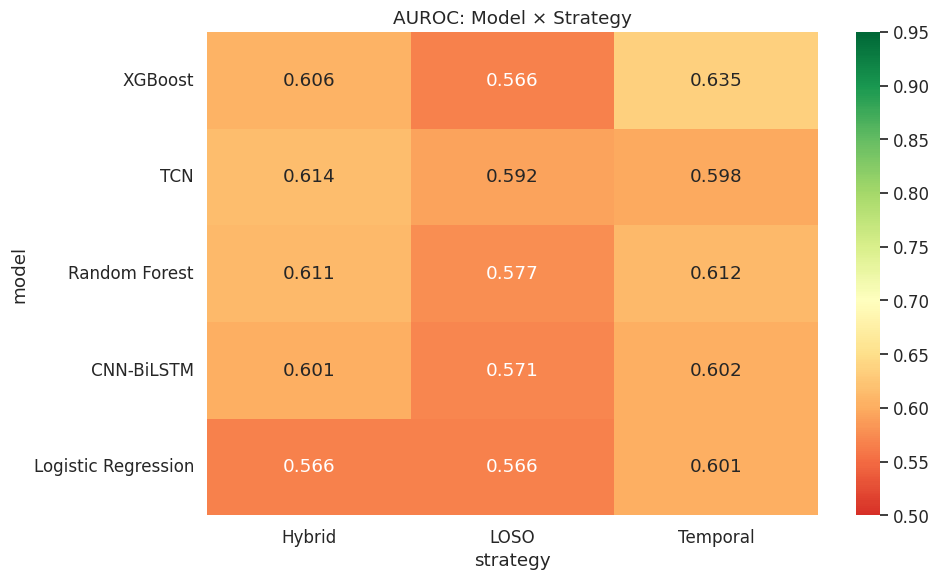

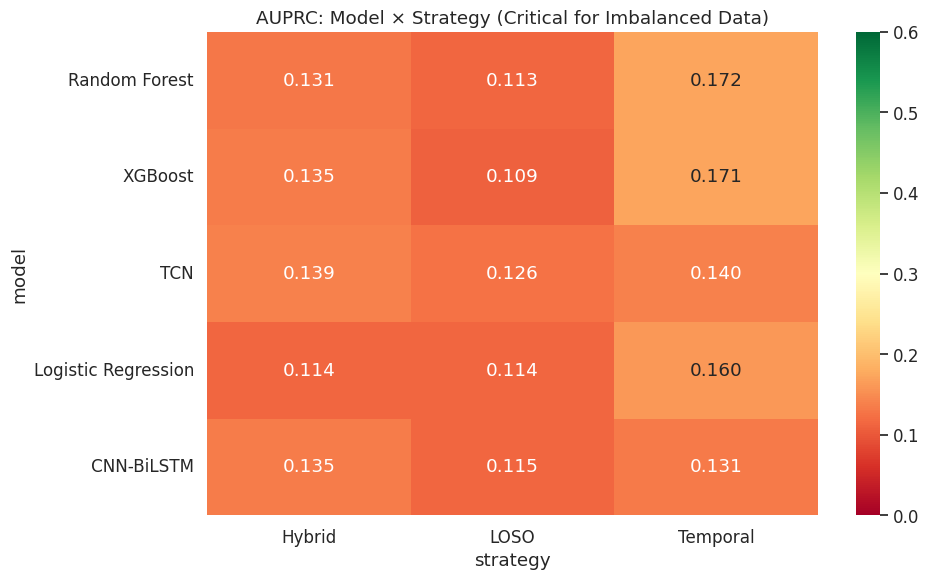

  Generating boxplots...


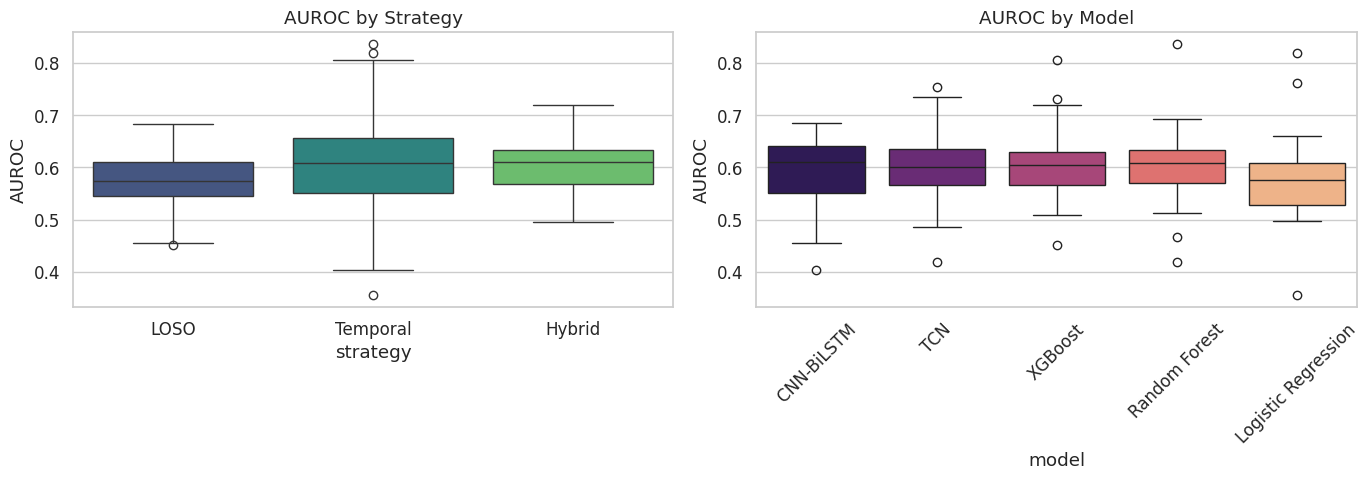

  Generating training curves...


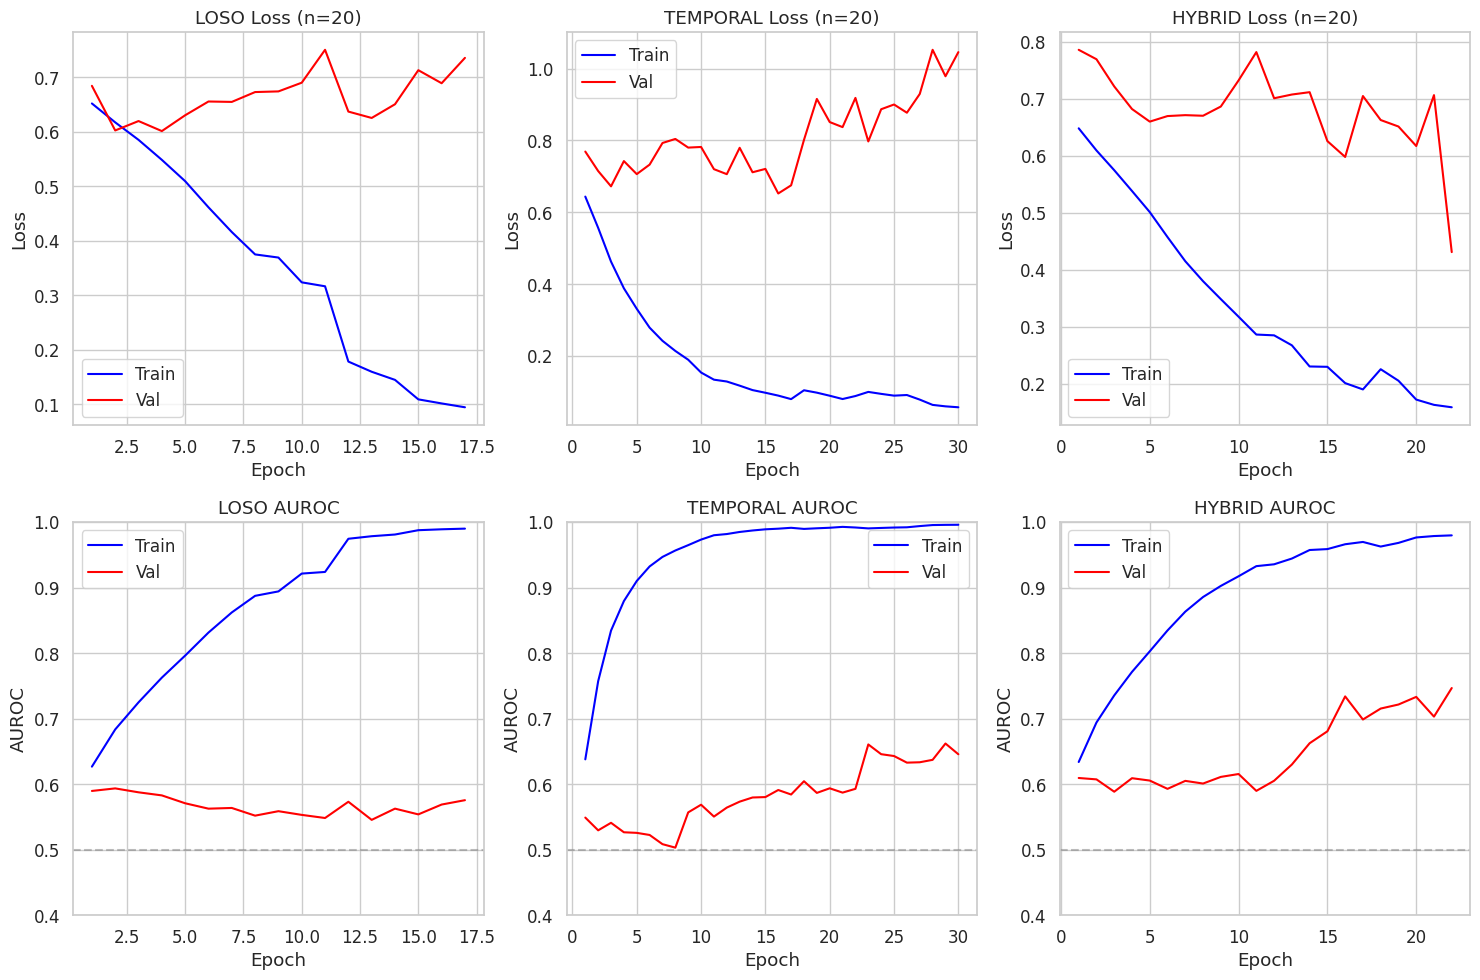

  Generating ROC/PR/Calibration curves...


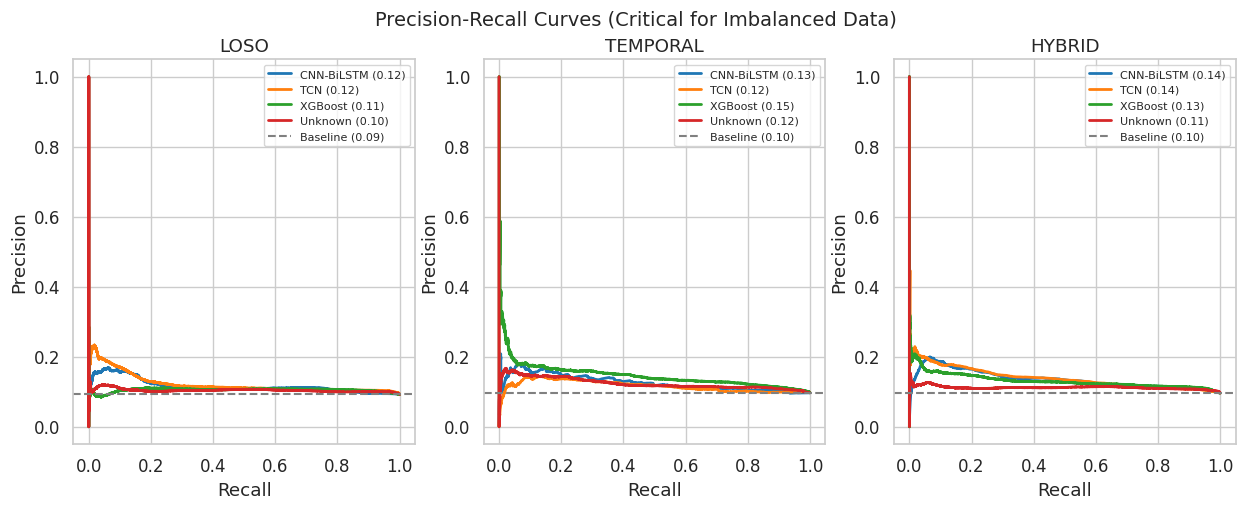

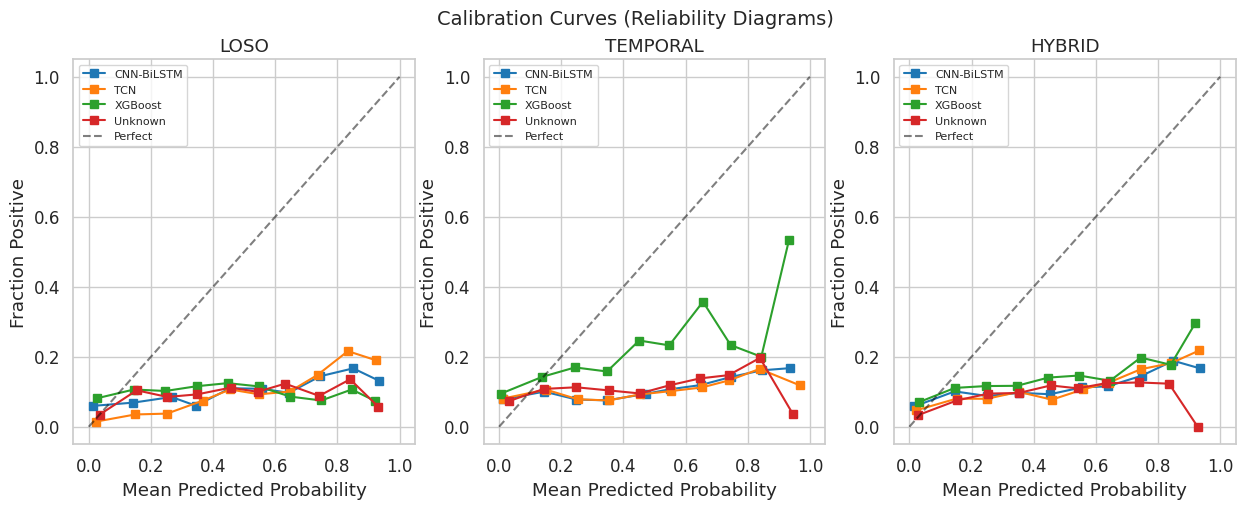

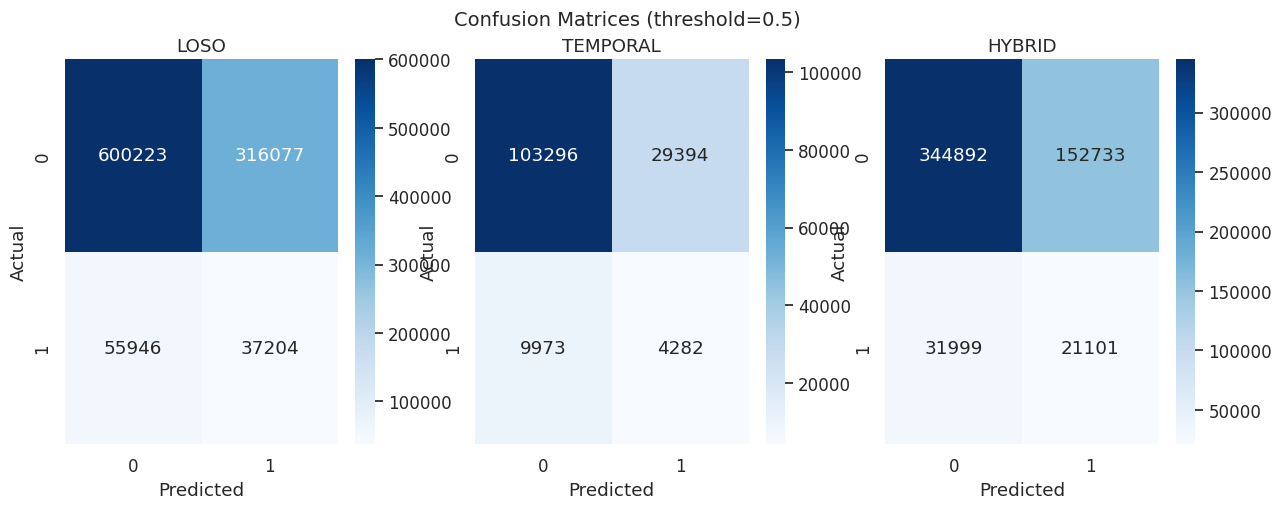

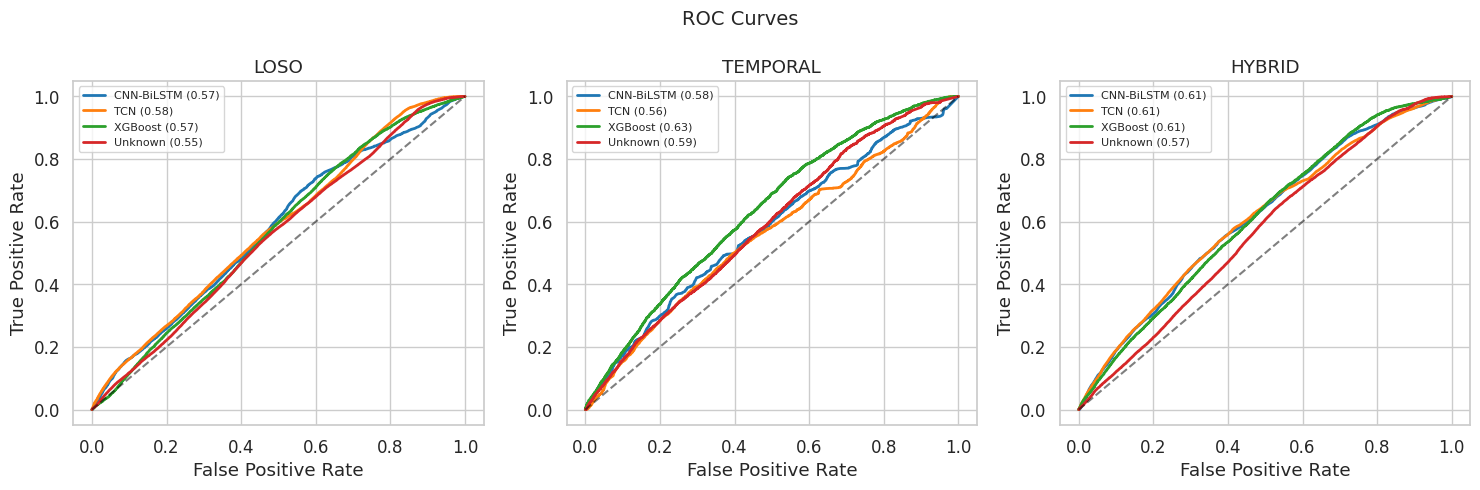

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

  Generating feature importance...


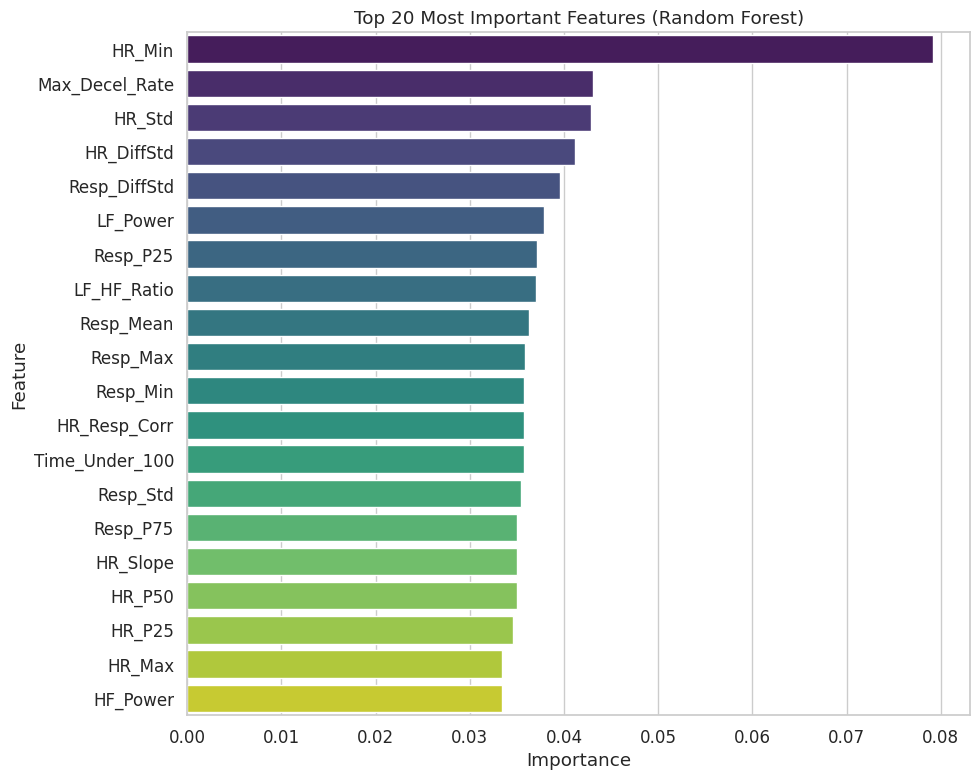


  All figures saved to: /content/drive/MyDrive/capstone_results/Merged_Optimized_Diagnostics/figures

  REPORT COMPLETE

  Total time: 3.3 minutes
  Results:    /content/drive/MyDrive/capstone_results/Merged_Optimized_Diagnostics/all_results.csv
  Figures:    /content/drive/MyDrive/capstone_results/Merged_Optimized_Diagnostics/figures


In [11]:
import os
import glob
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import wilcoxon
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, auc
from sklearn.calibration import calibration_curve
import warnings

# Global Plot Styling
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
warnings.filterwarnings('ignore')

# Data Reconstruction
def reconstruct_all_data(output_dir):
    """Reconstructs all results and predictions from disk."""
    results = []
    predictions = {}

    print("\nLoading data from disk...")
    for strategy in ['loso', 'temporal', 'hybrid']:
        pred_dir = os.path.join(output_dir, strategy, 'predictions')
        if not os.path.exists(pred_dir):
            continue

        for f in glob.glob(os.path.join(pred_dir, "*.npz")):
            try:
                data = np.load(f, allow_pickle=True)
                task_id = os.path.basename(f).replace('.npz', '')

                if 'result' in data:
                    res = data['result'].item()
                    if 'subject_id' not in res:
                        res['subject_id'] = res.get('test_infant', res.get('infant', 'unknown'))
                    results.append(res)

                if 'probs' in data and 'labels' in data:
                    predictions[task_id] = {
                        'probs': data['probs'],
                        'labels': data['labels']
                    }
            except Exception as e:
                print(f"  Warning: Could not load {os.path.basename(f)}: {e}")

    df = pd.DataFrame(results) if results else pd.DataFrame()
    print(f"  Found {len(df)} experiment results")
    print(f"  Found {len(predictions)} prediction files")

    return df, predictions


def reconstruct_histories(output_dir):
    """Reconstructs all training histories."""
    histories = {'loso': [], 'temporal': [], 'hybrid': []}
    for strategy in histories.keys():
        model_dir = os.path.join(output_dir, strategy, 'models')
        if not os.path.exists(model_dir):
            continue

        for fname in os.listdir(model_dir):
            if not fname.endswith('_history.npz'):
                continue
            try:
                path = os.path.join(model_dir, fname)
                data = np.load(path, allow_pickle=True)
                histories[strategy].append({k: data[k] for k in data.files})
            except:
                continue
    return histories


# TEXT REPORTING
def print_header(title, char='=', width=80):
    print(f"\n{char * width}\n  {title}\n{char * width}\n")


def print_subheader(title):
    print(f"\n  {'─'*60}\n  {title}\n  {'─'*60}")


def print_table(df, title=None):
    if title:
        print(f"\n  {title}:")
    if df.empty:
        print("  (No data)")
        return
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=False, floatfmt=".4f"))


def print_dataset_summary(infant_data, config):
    print_header("DATASET & CONFIGURATION")

    n_subjects = len(infant_data)
    total_samples = sum(len(d['y']) for d in infant_data.values())
    total_positives = sum(d['y'].sum() for d in infant_data.values())

    print(f"  Subjects:           {n_subjects}")
    print(f"  Total Samples:      {total_samples:,}")
    print(f"  Bradycardia Events: {int(total_positives):,}")
    print(f"  Positive Rate:      {100*total_positives/total_samples:.2f}%")

    print_subheader("Key Parameters")
    print(f"  Window / Horizon:   {config.WINDOW_LEN}s / {config.HORIZON}s")
    print(f"  Sampling Rate:      {config.FS_GRID} Hz")
    print(f"  Batch / LR / Epochs: {config.BATCH_SIZE} / {config.LEARNING_RATE} / {config.N_EPOCHS}")
    print(f"  Early Stopping:     patience={config.PATIENCE}")
    print(f"  Models:             {', '.join(config.MODELS)}")


def print_executive_summary(df):
    print_header("EXECUTIVE SUMMARY")
    if df.empty:
        print("  No results available.")
        return

    # Best result
    print_subheader("Best Overall Result")
    best = df.loc[df['auroc'].idxmax()]
    print(f"  Model:     {best['model']} ({best['strategy']})")
    print(f"  Subject:   {best.get('subject_id', 'N/A')}")
    print(f"  AUROC:     {best['auroc']:.4f}")
    if 'auprc' in df.columns:
        print(f"  AUPRC:     {best['auprc']:.4f}")

    # By strategy
    print_subheader("Performance by Strategy")
    strat = df.groupby('strategy')['auroc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
    print_table(strat.reset_index().round(4))

    # By model
    print_subheader("Performance by Model")
    model = df.groupby('model')['auroc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
    print_table(model.reset_index().round(4))


def print_performance_tables(df):
    print_header("DETAILED PERFORMANCE ANALYSIS")
    if df.empty:
        return

    # AUROC Matrix
    pivot_auroc = df.pivot_table(index='model', columns='strategy', values='auroc', aggfunc='mean')
    pivot_auroc['Mean'] = pivot_auroc.mean(axis=1)
    print_table(pivot_auroc.sort_values('Mean', ascending=False).reset_index().round(4), "AUROC: Model × Strategy")

    # AUPRC Matrix (critical for imbalanced bradycardia data)
    if 'auprc' in df.columns:
        print_subheader("AUPRC (Critical for Imbalanced Data)")
        pivot_auprc = df.pivot_table(index='model', columns='strategy', values='auprc', aggfunc='mean')
        pivot_auprc['Mean'] = pivot_auprc.mean(axis=1)
        print_table(pivot_auprc.sort_values('Mean', ascending=False).reset_index().round(4))

    # Clinical metrics - Sensitivity at fixed specificity
    if 'sens_at_90spec' in df.columns:
        print_subheader("Clinical Metrics: Sensitivity @ Fixed Specificity")
        print("  (How many bradycardia events do we catch at acceptable false alarm rates?)\n")

        sens90 = df.pivot_table(index='model', columns='strategy', values='sens_at_90spec', aggfunc='mean')
        sens90['Mean'] = sens90.mean(axis=1)
        print_table(sens90.sort_values('Mean', ascending=False).reset_index().round(4), "Sensitivity @ 90% Specificity")

        if 'sens_at_95spec' in df.columns:
            sens95 = df.pivot_table(index='model', columns='strategy', values='sens_at_95spec', aggfunc='mean')
            sens95['Mean'] = sens95.mean(axis=1)
            print_table(sens95.sort_values('Mean', ascending=False).reset_index().round(4), "Sensitivity @ 95% Specificity")


def print_fit_diagnostics(df, config):
    print_header("FIT DIAGNOSTICS")
    if 'train_auroc' not in df.columns or 'val_auroc' not in df.columns:
        print("  Train/Val AUROC not available.")
        return

    df = df.copy()
    df['gap'] = df['train_auroc'] - df['val_auroc']
    df['fit_status'] = df.apply(
        lambda r: 'Overfitting' if r['gap'] > config.OVERFIT_GAP_THRESHOLD
        else ('Underfitting' if r['val_auroc'] < config.UNDERFIT_AUROC_THRESHOLD else 'Good'),
        axis=1
    )

    # Summary table
    fit_summary = df.groupby(['strategy', 'fit_status']).size().unstack(fill_value=0)
    print_table(fit_summary.reset_index(), "Fit Status by Strategy")

    # Worst overfitting cases
    print_subheader("Top 5 Overfitting Risks")
    worst = df.nlargest(5, 'gap')[['strategy', 'model', 'subject_id', 'train_auroc', 'val_auroc', 'gap']]
    print_table(worst.round(4))


def print_statistical_tests(df, config):
    print_header("STATISTICAL SIGNIFICANCE")
    if df.empty:
        print("  No results.")
        return

    print("  Wilcoxon Signed-Rank Tests (paired by subject)")
    print("  Legend: *** p<0.001, ** p<0.01, * p<0.05\n")

    results = []
    comparisons = [('LOSO', 'Hybrid'), ('LOSO', 'Temporal'), ('Temporal', 'Hybrid')]

    for model_name in config.MODELS:
        df_m = df[df['model'] == model_name]
        try:
            pivot = df_m.pivot(index='subject_id', columns='strategy', values='auroc').dropna()
            if len(pivot) < 3:
                continue

            for s1, s2 in comparisons:
                if s1 not in pivot.columns or s2 not in pivot.columns:
                    continue
                stat, p = wilcoxon(pivot[s1], pivot[s2])
                diff = pivot[s2].mean() - pivot[s1].mean()
                sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
                results.append({
                    'Model': model_name,
                    'Comparison': f'{s1} vs {s2}',
                    'N': len(pivot),
                    'Diff': diff,
                    'P-Value': p,
                    'Sig': sig
                })
        except:
            continue

    if results:
        res_df = pd.DataFrame(results).sort_values('P-Value')
        print_table(res_df.round(4))

        # Highlight significant findings
        sig_results = [r for r in results if r['Sig']]
        if sig_results:
            print_subheader("Significant Findings")
            for r in sig_results:
                s1, s2 = r['Comparison'].split(' vs ')
                winner = s2 if r['Diff'] > 0 else s1
                print(f"  • {r['Model']}: {winner} significantly better (p={r['P-Value']:.4f})")
    else:
        print("  Insufficient paired data for statistical testing.")





# VISUALIZATIONS
def plot_heatmaps(df, fig_dir):
    """Generate AUROC and AUPRC heatmaps."""
    # AUROC
    pivot = df.pivot_table(index='model', columns='strategy', values='auroc', aggfunc='mean')
    pivot = pivot.reindex(pivot.mean(axis=1).sort_values(ascending=False).index)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', center=0.7, vmin=0.5, vmax=0.95)
    plt.title('AUROC: Model × Strategy')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, 'heatmap_auroc.png'), dpi=150)
    plt.show()

    # AUPRC
    if 'auprc' in df.columns:
        pivot2 = df.pivot_table(index='model', columns='strategy', values='auprc', aggfunc='mean')
        pivot2 = pivot2.reindex(pivot2.mean(axis=1).sort_values(ascending=False).index)
        plt.figure(figsize=(10, 6))
        sns.heatmap(pivot2, annot=True, fmt='.3f', cmap='RdYlGn', center=0.3, vmin=0, vmax=0.6)
        plt.title('AUPRC: Model × Strategy (Critical for Imbalanced Data)')
        plt.tight_layout()
        plt.savefig(os.path.join(fig_dir, 'heatmap_auprc.png'), dpi=150)
        plt.show()


def plot_boxplots(df, fig_dir):
    """Generate performance distribution boxplots."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.boxplot(data=df, x='strategy', y='auroc', ax=axes[0], palette="viridis")
    axes[0].set_title('AUROC by Strategy')
    axes[0].set_ylabel('AUROC')
    sns.boxplot(data=df, x='model', y='auroc', ax=axes[1], palette="magma")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_title('AUROC by Model')
    axes[1].set_ylabel('AUROC')
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, 'boxplots.png'), dpi=150)
    plt.show()axes[0, col].plot(ep, np.nanmean(tl,


def plot_training_curves(hist, fig_dir):
    """Generate training curves."""
    req = ['train_loss', 'val_loss', 'train_auroc', 'val_auroc']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for col, strat in enumerate(['loso', 'temporal', 'hybrid']):
        hlist = [h for h in hist.get(strat, []) if all(k in h for k in req)]
        if not hlist:
            axes[0, col].set_title(f'{strat.upper()} - No Data')
            axes[1, col].set_title(f'{strat.upper()} - No Data')
            continue

        maxe = max(len(h['train_loss']) for h in hlist)
        def pad(a, n):
            a = np.array(a, dtype=float)
            return np.concatenate([a, np.full(n - len(a), np.nan)]) if len(a) < n else a

        tl = np.array([pad(h['train_loss'], maxe) for h in hlist])
        vl = np.array([pad(h['val_loss'], maxe) for h in hlist])
        ta = np.array([pad(h['train_auroc'], maxe) for h in hlist])
        va = np.array([pad(h['val_auroc'], maxe) for h in hlist])
        ep = np.arange(1, maxe + 1)

        # Loss
        axes[0, col].plot(ep, np.nanmean(tl, 0), 'b-', label='Train')
        axes[0, col].plot(ep, np.nanmean(vl, 0), 'r-', label='Val')
        axes[0, col].set_title(f'{strat.upper()} Loss (n={len(hlist)})')
        axes[0, col].set_xlabel('Epoch')
        axes[0, col].set_ylabel('Loss')
        axes[0, col].legend()

        # AUROC
        axes[1, col].plot(ep, np.nanmean(ta, 0), 'b-', label='Train')
        axes[1, col].plot(ep, np.nanmean(va, 0), 'r-', label='Val')
        axes[1, col].axhline(0.5, color='gray', ls='--', alpha=0.5)
        axes[1, col].set_title(f'{strat.upper()} AUROC')
        axes[1, col].set_xlabel('Epoch')
        axes[1, col].set_ylabel('AUROC')
        axes[1, col].legend()
        axes[1, col].set_ylim(0.4, 1.0)

    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, 'training_curves.png'), dpi=150)
    plt.show()


def plot_curve_metrics(preds, fig_dir, config):
    """Generate ROC, PR, Calibration curves and Confusion Matrices."""
    if not preds:
        print("  No predictions available for curve plotting.")
        return

    fig_roc, ax_roc = plt.subplots(1, 3, figsize=(15, 5))
    fig_pr, ax_pr = plt.subplots(1, 3, figsize=(15, 5))
    fig_cal, ax_cal = plt.subplots(1, 3, figsize=(15, 5))
    fig_cm, ax_cm = plt.subplots(1, 3, figsize=(15, 5))

    for i, strat in enumerate(['loso', 'temporal', 'hybrid']):
        sp = {k: v for k, v in preds.items() if strat in k}
        if not sp:
            for ax in [ax_roc[i], ax_pr[i], ax_cal[i], ax_cm[i]]:
                ax.set_title(f'{strat.upper()} - No Data')
            continue

        # Aggregate predictions by model
        agg = {}
        for tid, p in sp.items():
            found = "Unknown"
            for mn in config.MODELS:
                if mn.lower().replace(" ", "_").replace("-", "_") in tid.lower().replace("-", "_"):
                    found = mn
                    break
            if found not in agg:
                agg[found] = {'l': [], 'p': []}
            agg[found]['l'].extend(p['labels'])
            agg[found]['p'].extend(p['probs'])

        all_l, all_p = [], []

        for name, d in agg.items():
            if len(np.unique(d['l'])) < 2:
                continue

            # ROC
            fpr, tpr, _ = roc_curve(d['l'], d['p'])
            ax_roc[i].plot(fpr, tpr, lw=2, label=f"{name} ({auc(fpr, tpr):.2f})")

            # PR
            prec, rec, _ = precision_recall_curve(d['l'], d['p'])
            ax_pr[i].plot(rec, prec, lw=2, label=f"{name} ({auc(rec, prec):.2f})")

            # Calibration
            try:
                frac_pos, mean_pred = calibration_curve(d['l'], d['p'], n_bins=10)
                ax_cal[i].plot(mean_pred, frac_pos, 's-', label=name)
            except:
                pass

            all_l.extend(d['l'])
            all_p.extend(d['p'])

        # Format ROC
        ax_roc[i].plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax_roc[i].set_title(f'{strat.upper()}')
        ax_roc[i].set_xlabel('False Positive Rate')
        ax_roc[i].set_ylabel('True Positive Rate')
        ax_roc[i].legend(fontsize=8)

        # Format PR with baseline
        if all_l:
            baseline = np.mean(all_l)
            ax_pr[i].axhline(baseline, color='gray', ls='--', label=f'Baseline ({baseline:.2f})')
        ax_pr[i].set_title(f'{strat.upper()}')
        ax_pr[i].set_xlabel('Recall')
        ax_pr[i].set_ylabel('Precision')
        ax_pr[i].legend(fontsize=8)

        # Format Calibration
        ax_cal[i].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect')
        ax_cal[i].set_title(f'{strat.upper()}')
        ax_cal[i].set_xlabel('Mean Predicted Probability')
        ax_cal[i].set_ylabel('Fraction Positive')
        ax_cal[i].legend(fontsize=8)

        # Confusion Matrix
        if all_l:
            cm = confusion_matrix(all_l, (np.array(all_p) >= 0.5).astype(int))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm[i])
            ax_cm[i].set_title(f'{strat.upper()}')
            ax_cm[i].set_xlabel('Predicted')
            ax_cm[i].set_ylabel('Actual')

    fig_roc.suptitle('ROC Curves', fontsize=14)
    fig_pr.suptitle('Precision-Recall Curves (Critical for Imbalanced Data)', fontsize=14)
    fig_cal.suptitle('Calibration Curves (Reliability Diagrams)', fontsize=14)
    fig_cm.suptitle('Confusion Matrices (threshold=0.5)', fontsize=14)

    for fig, name in [(fig_roc, 'roc'), (fig_pr, 'pr'), (fig_cal, 'calibration'), (fig_cm, 'confusion')]:
        fig.tight_layout()
        fig.savefig(os.path.join(fig_dir, f'{name}.png'), dpi=150)
        plt.figure(fig.number)
        plt.show()


def plot_feature_importance(infant_data, config, fig_dir):
    """Generate feature importance plot using TraditionalML wrapper."""
    if not infant_data:
        print("  No data for feature importance.")
        return

    try:
        # Use TraditionalML which extracts features and stores their names
        mdl = TraditionalML('Random Forest', config)

        Xa = np.concatenate([d['X'] for d in infant_data.values()])
        ya = np.concatenate([d['y'] for d in infant_data.values()])

        # Subsample for speed
        if len(ya) > 20000:
            idx = np.random.choice(len(ya), 20000, replace=False)
            Xa, ya = Xa[idx], ya[idx]

        mdl.fit(Xa, ya)

        if hasattr(mdl.model, 'feature_importances_'):
            fdf = pd.DataFrame({
                'Feature': mdl.feature_names,
                'Importance': mdl.model.feature_importances_
            })
            fdf = fdf.sort_values('Importance', ascending=False).head(20)

            plt.figure(figsize=(10, 8))
            sns.barplot(x='Importance', y='Feature', data=fdf, palette="viridis")
            plt.title('Top 20 Most Important Features (Random Forest)')
            plt.tight_layout()
            plt.savefig(os.path.join(fig_dir, 'feature_importance.png'), dpi=150)
            plt.show()
        else:
            print("  Model does not have feature_importances_ attribute.")
    except Exception as e:
        print(f"  Skipped feature importance: {e}")


def generate_all_figures(df, preds, hist, infant_data, config, output_dir):
    """Generate all visualizations."""
    print_header("VISUALIZATIONS")

    fig_dir = os.path.join(output_dir, 'figures')
    os.makedirs(fig_dir, exist_ok=True)

    print("  Generating heatmaps...")
    plot_heatmaps(df, fig_dir)

    print("  Generating boxplots...")
    plot_boxplots(df, fig_dir)

    print("  Generating training curves...")
    plot_training_curves(hist, fig_dir)

    print("  Generating ROC/PR/Calibration curves...")
    plot_curve_metrics(preds, fig_dir, config)

    print("  Generating feature importance...")
    plot_feature_importance(infant_data, config, fig_dir)

    print(f"\n  All figures saved to: {fig_dir}")


# MAIN
if __name__ == "__main__":
    start_time = time.time()

    # Run training if needed
    if len(infant_data) > 0:
        total_tasks = len(infant_data) * len(config.MODELS) * 3
        completed = len(tracker.progress.get('completed', []))
        if completed < total_tasks:
            print(f"\nRunning {total_tasks - completed} remaining tasks...")
            run_all_strategies()

    print_header("BRADYCARDIA PREDICTION - CAPSTONE REPORT")

    # Load data
    results_df, predictions = reconstruct_all_data(OUTPUT_DIR)
    histories = reconstruct_histories(OUTPUT_DIR)

    if results_df.empty:
        print("\n  ERROR: No results found. Run training first.")
    else:
        # Save results
        results_df.to_csv(os.path.join(OUTPUT_DIR, 'all_results.csv'), index=False)

        # Text Reports
        print_dataset_summary(infant_data, config)
        print_executive_summary(results_df)
        print_performance_tables(results_df)
        print_fit_diagnostics(results_df, config)
        print_statistical_tests(results_df, config)

        # Visualizations
        generate_all_figures(results_df, predictions, histories, infant_data, config, OUTPUT_DIR)

        # Legacy diagnostics
        try:
            generate_diagnostics(OUTPUT_DIR)
        except:
            pass

    print_header("REPORT COMPLETE")
    print(f"  Total time: {(time.time() - start_time)/60:.1f} minutes")
    print(f"  Results:    {os.path.join(OUTPUT_DIR, 'all_results.csv')}")
    print(f"  Figures:    {os.path.join(OUTPUT_DIR, 'figures')}")

# Stacking/ensemble Approaches (BEST RESULTS EVER!!! (see attempt 2))

Attempt 1

In [15]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression

# Load per-infant predictions (Temporal strategy only)
pred_dir = os.path.join(OUTPUT_DIR, 'temporal', 'predictions')
models_for_ensemble = ['CNN-BiLSTM', 'Random Forest', 'XGBoost']

preds = defaultdict(dict)       # preds[infant_id][model] = probs
labels_by_infant = {}           # labels_by_infant[infant_id] = y_true

for fname in os.listdir(pred_dir):
    if not fname.endswith('.npz'):
        continue

    data = np.load(os.path.join(pred_dir, fname), allow_pickle=True)
    if 'result' not in data:
        continue

    result = data['result'].item()
    if result.get('strategy') != 'Temporal':
        continue

    model_name = result.get('model')
    if model_name not in models_for_ensemble:
        continue

    infant_id = result.get('infant') or result.get('infant_id') or result.get('test_infant')
    if infant_id is None:
        continue

    probs = data['probs']
    labels = data['labels']

    preds[infant_id][model_name] = probs
    if infant_id in labels_by_infant:
        # Sanity check: labels must match across models
        if not np.array_equal(labels_by_infant[infant_id], labels):
            print(f"Warning: label mismatch for {infant_id} between models!")
    else:
        labels_by_infant[infant_id] = labels

# Keep only infants that have all required models
valid_infants = sorted(
    [inf for inf in preds.keys()
     if all(m in preds[inf] for m in models_for_ensemble)]
)

print("Infants used for ensembles:", valid_infants)




# Per-infant performance per model (for reference and for weights)
rows_auroc = []
rows_auprc = []
model_aurocs = {m: [] for m in models_for_ensemble}
model_auprcs = {m: [] for m in models_for_ensemble}

for infant_id in valid_infants:
    y_true = labels_by_infant[infant_id]
    row_auc = {'infant_id': infant_id}
    row_auprc = {'infant_id': infant_id}
    for m in models_for_ensemble:
        y_pred = preds[infant_id][m]
        auroc = roc_auc_score(y_true, y_pred)
        auprc = average_precision_score(y_true, y_pred)
        row_auc[m] = auroc
        row_auprc[m] = auprc
        model_aurocs[m].append(auroc)
        model_auprcs[m].append(auprc)
    rows_auroc.append(row_auc)
    rows_auprc.append(row_auprc)

df_auroc = pd.DataFrame(rows_auroc).set_index('infant_id')
df_auprc = pd.DataFrame(rows_auprc).set_index('infant_id')

print("\nPer-infant AUROC (base models):")
print(df_auroc.round(4))

print("\nPer-infant AUPRC (base models):")
print(df_auprc.round(4))

# Weighted ensemble (weights from mean AUROC across infants)
mean_aurocs = {m: float(np.mean(model_aurocs[m])) for m in models_for_ensemble}
total_auc = sum(mean_aurocs.values())
weights = {m: mean_aurocs[m] / total_auc for m in models_for_ensemble}

print("\nModel mean AUROCs (for weighting):")
for m in models_for_ensemble:
    print(f"  {m:15s}: {mean_aurocs[m]:.4f}")
print("\nNormalized weights (sum to 1):")
for m in models_for_ensemble:
    print(f"  {m:15s}: {weights[m]:.4f}")

# Compute ensemble performance per infant
ensemble_rows = []
for infant_id in valid_infants:
    y_true = labels_by_infant[infant_id]
    # Weighted average of probabilities
    ens_probs = np.zeros_like(y_true, dtype=float)
    for m in models_for_ensemble:
        ens_probs += weights[m] * preds[infant_id][m]

    auroc = roc_auc_score(y_true, ens_probs)
    auprc = average_precision_score(y_true, ens_probs)
    ensemble_rows.append({'infant_id': infant_id, 'auroc': auroc, 'auprc': auprc})

df_ensemble = pd.DataFrame(ensemble_rows).set_index('infant_id')

print("\nWeighted ensemble per-infant performance:")
print(df_ensemble.round(4))

print("\nWeighted ensemble mean performance:")
print(f"  AUROC: {df_ensemble['auroc'].mean():.4f}")
print(f"  AUPRC: {df_ensemble['auprc'].mean():.4f}")




# Stacked meta-learner (logistic regression on [CNN, RF, XGB])
#    Using LOSO for the meta-learner
meta_rows = []

for held_out in valid_infants:
    # Build meta-training set from all *other* infants
    X_train_meta_list = []
    y_train_meta_list = []

    for inf in valid_infants:
        if inf == held_out:
            continue
        y = labels_by_infant[inf]
        # Features = [CNN, RF, XGB] probs
        X = np.vstack([preds[inf][m] for m in models_for_ensemble]).T
        X_train_meta_list.append(X)
        y_train_meta_list.append(y)

    X_train_meta = np.concatenate(X_train_meta_list, axis=0)
    y_train_meta = np.concatenate(y_train_meta_list, axis=0)

    # Train meta-learner
    meta_clf = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        solver='lbfgs'
    )
    meta_clf.fit(X_train_meta, y_train_meta)

    # Test on held-out infant
    y_test = labels_by_infant[held_out]
    X_test_meta = np.vstack([preds[held_out][m] for m in models_for_ensemble]).T
    y_meta_prob = meta_clf.predict_proba(X_test_meta)[:, 1]

    auroc = roc_auc_score(y_test, y_meta_prob)
    auprc = average_precision_score(y_test, y_meta_prob)

    meta_rows.append({'infant_id': held_out, 'auroc': auroc, 'auprc': auprc})

df_meta = pd.DataFrame(meta_rows).set_index('infant_id')

print("\nStacked meta-learner per-infant performance:")
print(df_meta.round(4))

print("\nStacked meta-learner mean performance:")
print(f"  AUROC: {df_meta['auroc'].mean():.4f}")
print(f"  AUPRC: {df_meta['auprc'].mean():.4f}")


# Compare stacked vs best single model per infant
best_single_rows = []
for infant_id in valid_infants:
    y_true = labels_by_infant[infant_id]

    # Find best base model for this infant (by AUROC)
    best_model = None
    best_auc = -np.inf
    best_pr = None

    for m in models_for_ensemble:
        y_pred = preds[infant_id][m]
        auc = roc_auc_score(y_true, y_pred)
        pr = average_precision_score(y_true, y_pred)
        if auc > best_auc:
            best_auc = auc
            best_pr = pr
            best_model = m

    best_single_rows.append({
        'infant_id': infant_id,
        'best_single_model': best_model,
        'best_single_auroc': best_auc,
        'best_single_auprc': best_pr,
        'stacked_auroc': df_meta.loc[infant_id, 'auroc'],
        'stacked_auprc': df_meta.loc[infant_id, 'auprc'],
        'weighted_auroc': df_ensemble.loc[infant_id, 'auroc'],
        'weighted_auprc': df_ensemble.loc[infant_id, 'auprc'],
    })

df_compare = pd.DataFrame(best_single_rows).set_index('infant_id')

print("\nStacked / weighted vs best single model per infant:")
print(df_compare.round(4))

print("\nAverage AUROC gain (stacked - best single):",
      float((df_compare['stacked_auroc'] - df_compare['best_single_auroc']).mean()))
print("Average AUPRC gain (stacked - best single):",
      float((df_compare['stacked_auprc'] - df_compare['best_single_auprc']).mean()))

print("\nAverage AUROC gain (weighted - best single):",
      float((df_compare['weighted_auroc'] - df_compare['best_single_auroc']).mean()))
print("Average AUPRC gain (weighted - best single):",
      float((df_compare['weighted_auprc'] - df_compare['best_single_auprc']).mean()))


Infants used for ensembles: ['infant1', 'infant10', 'infant2', 'infant3', 'infant4', 'infant5', 'infant6', 'infant7', 'infant8', 'infant9']

Per-infant AUROC (base models):
           CNN-BiLSTM  Random Forest  XGBoost
infant_id                                    
infant1        0.6190         0.5341   0.6057
infant10       0.5496         0.6079   0.7316
infant2        0.6471         0.6100   0.6205
infant3        0.5941         0.6815   0.6326
infant4        0.6857         0.5454   0.5094
infant5        0.6571         0.5791   0.6027
infant6        0.5951         0.6574   0.7165
infant7        0.6509         0.8358   0.8068
infant8        0.4023         0.4183   0.5124
infant9        0.6172         0.6555   0.6098

Per-infant AUPRC (base models):
           CNN-BiLSTM  Random Forest  XGBoost
infant_id                                    
infant1        0.1570         0.1018   0.1849
infant10       0.0571         0.0575   0.0738
infant2        0.1686         0.1380   0.2276
infant3     

XGB META-LEARNER GETS BEST RESULTS FROM ALL 12 VERSIONS OF CODE TRIED SO FAR!!!🥳🥳🥳

WITH A MEAN AUROC OF 74 - A FULL 10 POINTS HIGHER THAN THE PREVIOUS HIGH!!!🤯🤯🤯

In [16]:
import os
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Load saved temporal predictions for base models
base_models = ['CNN-BiLSTM', 'Random Forest', 'XGBoost']
pred_dir = os.path.join(OUTPUT_DIR, 'temporal', 'predictions')

# preds[infant_id][model_name] = {'probs': ..., 'labels': ...}
preds = {}
infants = set()

for fname in os.listdir(pred_dir):
    if not fname.endswith('.npz'):
        continue
    path = os.path.join(pred_dir, fname)
    data = np.load(path, allow_pickle=True)
    result = data['result'].item()
    model = result['model']
    if model not in base_models:
        continue

    infant_id = result.get('infant') or result.get('infant_id') or result.get('test_infant')
    infants.add(infant_id)

    if infant_id not in preds:
        preds[infant_id] = {}
    preds[infant_id][model] = {
        'probs': data['probs'],
        'labels': data['labels']
    }

infants = sorted(infants)
print("Infants used:", infants)

# Sanity check: ensure we have all 3 models for each infant
for inf in infants:
    missing = [m for m in base_models if m not in preds[inf]]
    if missing:
        print(f"WARNING: infant {inf} missing models: {missing}")



# Compute per-infant base-model metrics (for reference)
rows_auroc = []
rows_auprc = []

for inf in infants:
    y = None
    for m in base_models:
        p = preds[inf][m]['probs']
        if y is None:
            y = preds[inf][m]['labels']
        else:
            assert np.array_equal(y, preds[inf][m]['labels']), f"Label mismatch for {inf}"

        try:
            auroc = roc_auc_score(y, p)
            auprc = average_precision_score(y, p)
        except ValueError:
            auroc = 0.5
            auprc = y.mean()

        rows_auroc.append({'infant_id': inf, 'model': m, 'auroc': auroc})
        rows_auprc.append({'infant_id': inf, 'model': m, 'auprc': auprc})

df_auroc = pd.pivot_table(pd.DataFrame(rows_auroc),
                          index='infant_id',
                          columns='model',
                          values='auroc')
df_auprc = pd.pivot_table(pd.DataFrame(rows_auprc),
                          index='infant_id',
                          columns='model',
                          values='auprc')

print("\nPer-infant AUROC (base models):")
print(df_auroc.round(4))

print("\nPer-infant AUPRC (base models):")
print(df_auprc.round(4))



# Build meta-dataset from all infants' predictions
#    Features = [p_cnn, p_rf, p_xgb], Label = y
X_list = []
y_list = []
inf_list = []

for inf in infants:
    # Assume all models share labels
    y = preds[inf][base_models[0]]['labels']
    P = np.column_stack([preds[inf][m]['probs'] for m in base_models])
    X_list.append(P)
    y_list.append(y)
    inf_list.extend([inf] * len(y))

X_all = np.vstack(X_list)
y_all = np.concatenate(y_list)
inf_all = np.array(inf_list)

print("\nMeta-dataset shape:", X_all.shape, "labels shape:", y_all.shape)


# Helper to do CV stacking for a given meta-model
def cv_meta_model(X, y, inf_ids, MetaModel, model_name, n_splits=5):
    """
    X: (N, n_models) base probs
    y: (N,) labels
    inf_ids: (N,) infant_id string per sample
    MetaModel: callable that returns a fresh sklearn-like model
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    oof_probs = np.zeros_like(y, dtype=float)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        model = MetaModel()
        model.fit(X[train_idx], y[train_idx])
        oof_probs[val_idx] = model.predict_proba(X[val_idx])[:, 1]
        print(f"{model_name} CV fold {fold}/{n_splits} done")

    # Overall metrics
    try:
        auroc = roc_auc_score(y, oof_probs)
        auprc = average_precision_score(y, oof_probs)
    except ValueError:
        auroc = 0.5
        auprc = y.mean()

    # Per-infant metrics
    rows = []
    for inf in sorted(set(inf_ids)):
        idx = (inf_ids == inf)
        y_i = y[idx]
        p_i = oof_probs[idx]
        try:
            auroc_i = roc_auc_score(y_i, p_i)
            auprc_i = average_precision_score(y_i, p_i)
        except ValueError:
            auroc_i = 0.5
            auprc_i = y_i.mean()
        rows.append({'infant_id': inf, 'auroc': auroc_i, 'auprc': auprc_i})

    df_meta = pd.DataFrame(rows).set_index('infant_id')

    return auroc, auprc, df_meta, oof_probs



# Logistic regression stacker (calibration-ish stacker)
def make_logreg():
    return LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='liblinear',
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_SEED
    )

print("\n=== Logistic Regression Stacker (CV OOF) ===")
lr_auroc, lr_auprc, df_lr, lr_probs = cv_meta_model(
    X_all, y_all, inf_all, make_logreg, "LogReg Stacker", n_splits=5
)

print("\nPer-infant performance (LogReg stacker):")
print(df_lr.round(4))

print("\nLogReg stacker mean performance:")
print(f"  AUROC: {lr_auroc:.4f}")
print(f"  AUPRC: {lr_auprc:.44f}")



# Non-linear meta-learner (XGBoost) on top of base probs
def make_xgb_meta():
    return XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='auc',
        random_state=RANDOM_SEED,
        n_jobs=-1
    )

print("\n=== XGBoost Meta-Learner (CV OOF) ===")
xgbm_auroc, xgbm_auprc, df_xgbm, xgbm_probs = cv_meta_model(
    X_all, y_all, inf_all, make_xgb_meta, "XGB Meta", n_splits=5
)

print("\nPer-infant performance (XGB meta-learner):")
print(df_xgbm.round(4))

print("\nXGB meta-learner mean performance:")
print(f"  AUROC: {xgbm_auroc:.4f}")
print(f"  AUPRC: {xgbm_auprc:.4f}")



# Compare to best single model per infant
best_rows = []
for inf in infants:
    # Choose model with best AUROC
    aurocs = df_auroc.loc[inf]
    best_model = aurocs.idxmax()
    best_auroc = aurocs.max()
    best_auprc = df_auprc.loc[inf, best_model]

    best_rows.append({
        'infant_id': inf,
        'best_single_model': best_model,
        'best_single_auroc': best_auroc,
        'best_single_auprc': best_auprc,
        'lr_auroc': df_lr.loc[inf, 'auroc'],
        'lr_auprc': df_lr.loc[inf, 'auprc'],
        'xgbm_auroc': df_xgbm.loc[inf, 'auroc'],
        'xgbm_auprc': df_xgbm.loc[inf, 'auprc']
    })

df_compare = pd.DataFrame(best_rows).set_index('infant_id')

df_compare['delta_lr_auroc'] = df_compare['lr_auroc'] - df_compare['best_single_auroc']
df_compare['delta_lr_auprc'] = df_compare['lr_auprc'] - df_compare['best_single_auprc']
df_compare['delta_xgbm_auroc'] = df_compare['xgbm_auroc'] - df_compare['best_single_auroc']
df_compare['delta_xgbm_auprc'] = df_compare['xgbm_auprc'] - df_compare['best_single_auprc']

print("\nStackers vs best single model per infant:")
print(df_compare.round(4))

print("\nAverage gains (stacker - best single):")
print(f"  LogReg AUROC gain : {df_compare['delta_lr_auroc'].mean():.4f}")
print(f"  LogReg AUPRC gain : {df_compare['delta_lr_auprc'].mean():.44f}")
print(f"  XGB   AUROC gain  : {df_compare['delta_xgbm_auroc'].mean():.4f}")
print(f"  XGB   AUPRC gain  : {df_compare['delta_xgbm_auprc'].mean():.44f}")


Infants used: ['infant1', 'infant10', 'infant2', 'infant3', 'infant4', 'infant5', 'infant6', 'infant7', 'infant8', 'infant9']

Per-infant AUROC (base models):
model      CNN-BiLSTM  Random Forest  XGBoost
infant_id                                    
infant1        0.6190         0.5341   0.6057
infant10       0.5496         0.6079   0.7316
infant2        0.6471         0.6100   0.6205
infant3        0.5941         0.6815   0.6326
infant4        0.6857         0.5454   0.5094
infant5        0.6571         0.5791   0.6027
infant6        0.5951         0.6574   0.7165
infant7        0.6509         0.8358   0.8068
infant8        0.4023         0.4183   0.5124
infant9        0.6172         0.6555   0.6098

Per-infant AUPRC (base models):
model      CNN-BiLSTM  Random Forest  XGBoost
infant_id                                    
infant1        0.1570         0.1018   0.1849
infant10       0.0571         0.0575   0.0738
infant2        0.1686         0.1380   0.2276
infant3        0.1497     

# LLM Useage Disclosure

#### I used the following LLMs:

* Opus 4.5
* Sonnet 4.5
* Gemini 2.5 & 3.0
* ChatGPT 5.0 & 5.1
* Google Colab AI code completion (Codey)

#### For the following general tasks:
* Brainstorming & planning
* Autocomplete suggestions
* Debugging/error explainations
* Feedback & suggestions for improving code
* Improveing readability (refactoring, commenting, etc.)
* Optimizing runtime performance (e.g., vectorizing feature extraction)

### Specific LLM usages

#### Readability:
* Comments
* Docstrings
* Organizing
* Refactoring
* PEP 8 compliance
* General tidying up & neatness
* `print`s for logging/debugging
* Making the outputs more readable (e.g., "="*70)

---

#### Doublechecking for Potential Missed/Hidden Data Leakage Issues:
* Asked all LLMs to check code for potential data leakage and suggest optimal ways of dealing with it (such as for the hybrid-splitting code in `run_all_strategies`).

---

#### Optimizing Runtime Speed/Performance:
* Gemini 3 suggested & helped with vectorizing feature extraction & window generation (in `make_windows` & `_features`)
* Automatic Mixed Precision (AMP) implementation

---

#### Preemptive/defensive coding & error handling:
* Used LLMs to identify & improve parts of the code that might fail and could benefit from error handling safeguards (to avoid wasting time & GPU credits on long/overnight runs that end up crashing).

---

#### Google Drive integration:
* At one point started getting some weird annoying "mountpoint" error in Collab. Used one of the LLMs (I think ChatGPT) to realize that it was probably due to some local ghost file (not sure why) and make the mounting code more robust.

---

#### Checkpoint logic:
* LLMs helped with writing code to automatically save all potentially relevant training information to Google Drive, including:
  * training history,
  * `progresstracker` (w/ atomic file writes),
  * automatic skip trainings that were already done.

---

#### Visualizations:
* 4-panel diagnostic plots with automated overfitting detection: The code to place the "DIAGNOSIS" text box (ax4.text(...)) with manual coordinate transforms and bounding boxes (bbox=dict(boxstyle='round'...)).
* Aggregate analysis with NaN-padding logic: The `plot_aggregate_learning_curves` function manually pads lists with np.nan to handle histories of different lengths (due to early stopping) before averaging them.
* Functions like `plot_overfitting_analysis(results_df)` that use a particular column schema on `results_df` to make nicer figures.

---

#### Diagnosis Logic:
* The `if/elif` block defining "OVERFITTING" vs "UNDERFITTING" based on thresholds is a literal translation of a requirement prompt.

---

#### TCN Suggestion:
* LLMs suggested concatenating "Global Average Pooling" (GAP) and the "Last Timestep" to enable the model look at the whole history, while prioritizing the most recent second.

---

#### The `WeightedRandomSampler` Math:
* Used LLMs to help with the `make_weighted_sampler_with_target` to get the exact sampling weights required to force a batch to have a specific ratio of positives, regardless of the dataset's actual imbalance.

----

#### Misc.:
* Using a @dataclass for configuration